<a href="https://colab.research.google.com/github/gonzalezulises/DeepLearningWork/blob/main/Practica_Final_POI_Engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import random
import ast
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import roc_auc_score

SEED = 9

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# --- Configuraciones de Visualización (Opcional, para mejorar los gráficos) ---
sns.set_theme(style="whitegrid") # Un estilo agradable para los gráficos de Seaborn
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño por defecto de las figuras (ancho, alto en pulgadas)
plt.rcParams['axes.titlesize'] = 14 # Tamaño del título de los gráficos
plt.rcParams['axes.labelsize'] = 12 # Tamaño de las etiquetas de los ejes
print("Configuración inicial completada.")

Configuración inicial completada.


In [4]:
# Creación del directorio de extracción
# drive_project_path = '/content/drive/MyDrive/Colab Notebooks/Proyecto_POI_Engagement'
#zip_path = os.path.join(drive_project_path, 'data/data_main.zip')
#extract_path = os.path.join(drive_project_path, 'data/')
#os.makedirs(extract_path, exist_ok=True)
#print(f"Contenido del directorio de datos: {os.listdir(extract_path)}")

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

#print(f"Archivos extraídos en: {extract_path}")
#print(os.listdir(extract_path))

In [5]:
# Rutas de trabajo
DRIVE_PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/'
DATA_PATH = os.path.join(DRIVE_PROJECT_PATH, 'data/')
METADATA_FILE = os.path.join(DATA_PATH, 'poi_dataset.csv')
IMAGES_BASE_FOLDER = os.path.join(DATA_PATH, 'data_main/')

In [6]:
print(f"Ruta del proyecto en Drive: {DRIVE_PROJECT_PATH}")
print(f"Ruta de la carpeta de datos: {DATA_PATH}")
print(f"Ruta del archivo de metadatos: {METADATA_FILE}")
print(f"Ruta base de las imágenes: {IMAGES_BASE_FOLDER}")

Ruta del proyecto en Drive: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/
Ruta de la carpeta de datos: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/
Ruta del archivo de metadatos: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/poi_dataset.csv
Ruta base de las imágenes: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/


In [7]:
df_meta = pd.read_csv(METADATA_FILE)
print(f"Archivo de metadatos '{os.path.basename(METADATA_FILE)}' cargado exitosamente.")
print(f"El DataFrame 'df_meta' tiene {df_meta.shape[0]} filas (POIs) y {df_meta.shape[1]} columnas (características).")

# --- Inspección Inicial del DataFrame ---
print("\n--- Primeras 3 filas del DataFrame 'df_meta': ---")
df_meta.info()

Archivo de metadatos 'poi_dataset.csv' cargado exitosamente.
El DataFrame 'df_meta' tiene 1569 filas (POIs) y 14 columnas (características).

--- Primeras 3 filas del DataFrame 'df_meta': ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int6

# Análisis Exploratorio de Datos (EDA) - Metadatos (Continuación)

In [8]:
# --- Estadísticas Descriptivas para Columnas Numéricas ---
print("\n--- Estadísticas Descriptivas para Columnas Numéricas en 'df_meta' ---")
# .describe() para columnas numéricas (int, float).
# .T transpone la tabla para que sea más fácil de leer.
display(df_meta.describe(include=[np.number]).T)

# --- Estadísticas Descriptivas para Columnas de Texto/Categóricas (object) ---
print("\n--- Estadísticas Descriptivas para Columnas de Texto/Categóricas (object) en 'df_meta' ---")
# .describe() para columnas de tipo 'object'.
display(df_meta.describe(include=['object']).T)


--- Estadísticas Descriptivas para Columnas Numéricas en 'df_meta' ---


,count,mean,std,min,25%,50%,75%,max
tier,1569.0,1.541109,0.637677,1.000000,1.000000,1.000000,2.000000,4.000000
locationLon,1569.0,-1.132337,22.733401,-121.951049,-3.725292,-3.699140,-3.673348,158.333118
locationLat,1569.0,39.900141,9.662134,-62.940930,40.411754,40.421738,40.472458,65.706572
xps,1569.0,750.382409,228.319854,0.000000,600.000000,700.000000,1000.000000,1000.000000
Visits,1569.0,10011.943276,5.456808,10001.000000,10008.000000,10011.000000,10015.000000,10038.000000
Likes,1569.0,3623.908222,4817.879374,100.000000,464.000000,1434.000000,6840.000000,26425.000000
Dislikes,1569.0,2526.305927,2225.543360,52.000000,937.000000,2718.000000,3399.000000,10999.000000
Bookmarks,1569.0,973.261950,1453.333948,50.000000,116.000000,306.000000,1309.000000,8157.000000



--- Estadísticas Descriptivas para Columnas de Texto/Categóricas (object) en 'df_meta' ---


,count,unique,top,freq
id,1569,1492,a0f3f39c-fc87-4031-900d-d4776b1f3491,7
name,1569,1458,Ambresbury Banks en el bosque de Epping,7
shortDescription,1569,1491,"Explora Ambresbury Banks en Epping Forest, un ...",7
categories,1569,224,"['Patrimonio', 'Historia', 'Arquitectura']",100
tags,1569,1418,[],107
main_image_path,1569,1492,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...,7


In [9]:
# --- Confirmación de Ausencia de Valores Faltantes ---
print("\n--- Verificación Explícita de Valores Faltantes en 'df_meta' ---")
missing_values_check = df_meta.isnull().sum()

if missing_values_check.sum() == 0:
    print("¡Confirmado! No hay valores faltantes (NaN o Nulos) en ninguna columna del DataFrame.")
else:
    print("Se encontraron los siguientes valores faltantes por columna:")
    display(missing_values_check[missing_values_check > 0])


--- Verificación Explícita de Valores Faltantes en 'df_meta' ---
¡Confirmado! No hay valores faltantes (NaN o Nulos) en ninguna columna del DataFrame.


Conclusiones Clave de esta Etapa Inicial del EDA:

No hay valores faltantes.
IDs Duplicados: El problema más urgente a investigar son los IDs duplicados. Esto podría significar que hay filas enteras repetidas o que diferentes filas comparten el mismo identificador por error.
Columna Visits Sospechosa: El rango y la distribución de Visits son muy extraños y necesitan un análisis más detallado.
Coordenadas Geográficas Amplias: locationLon y locationLat necesitan ser visualizadas para entender su dispersión.
Columnas de Listas como Strings: categories y tags necesitarán ser procesadas para convertirlas de strings a listas reales de categorías/tags.


In [10]:
print("\n--- Investigación de IDs Duplicados ---")
# Contar la frecuencia de cada ID
id_counts = df_meta['id'].value_counts()

# Filtrar para obtener solo los IDs que aparecen más de una vez
duplicated_ids = id_counts[id_counts > 1].index.tolist()

if duplicated_ids:
    print(f"Se encontraron {len(duplicated_ids)} IDs que están duplicados.")
    print(f"El ID más frecuente es '{id_counts.index[0]}' y aparece {id_counts.iloc[0]} veces.")

    # Mostrar las filas completas para algunos de los IDs duplicados para inspección
    # Vamos a ver todas las ocurrencias del ID más duplicado
    print(f"\n--- Mostrando todas las filas para el ID más duplicado: {id_counts.index[0]} ---")
    display(df_meta[df_meta['id'] == id_counts.index[0]])

    # Opcional: Ver las primeras N filas duplicadas
    # print("\n--- Primeras filas correspondientes a algunos IDs duplicados: ---")
    # display(df_meta[df_meta['id'].isin(duplicated_ids)].sort_values(by='id').head(10)) # Muestra 10 filas ordenadas por ID

    # Verificar si las filas duplicadas (basadas en ID) son completamente idénticas
    # Tomamos el ID más frecuente como ejemplo
    example_duplicated_df = df_meta[df_meta['id'] == id_counts.index[0]]
    if not example_duplicated_df.empty:
        # .duplicated(keep=False) marca todas las ocurrencias de duplicados
        # Si todas las columnas son iguales para un mismo ID, entonces son filas completamente duplicadas
        num_fully_duplicated_rows_for_id = example_duplicated_df.duplicated().sum()
        if num_fully_duplicated_rows_for_id == (len(example_duplicated_df) -1 ): # -1 porque la primera ocurrencia no se marca como duplicada por .duplicated() simple
             print(f"\nPara el ID {id_counts.index[0]}, todas sus {len(example_duplicated_df)} apariciones parecen ser filas completamente idénticas.")
        else:
             print(f"\nPara el ID {id_counts.index[0]}, sus {len(example_duplicated_df)} apariciones NO son todas idénticas en todas las columnas.")
             # Podrías querer ver las diferencias:
             # display(example_duplicated_df.drop_duplicates().T.join(example_duplicated_df.drop_duplicates(keep='last').T, lsuffix='_first', rsuffix='_last').T)


else:
    print("No se encontraron IDs duplicados. Esto contradice las estadísticas anteriores, revisar.")

# --- Decisión sobre duplicados (a tomar DESPUÉS de la inspección) ---
# Si las filas con el mismo ID son completamente idénticas, podemos eliminarlas quedándonos con una sola.
# df_meta_no_duplicates = df_meta.drop_duplicates(subset=['id'], keep='first')
# print(f"\nSi eliminamos duplicados por 'id' (quedándonos con la primera ocurrencia), el DataFrame tendría {len(df_meta_no_duplicates)} filas.")
# Esta línea de arriba es para consideración, NO la ejecutes como acción definitiva aún.


--- Investigación de IDs Duplicados ---
Se encontraron 23 IDs que están duplicados.
El ID más frecuente es 'a0f3f39c-fc87-4031-900d-d4776b1f3491' y aparece 7 veces.

--- Mostrando todas las filas para el ID más duplicado: a0f3f39c-fc87-4031-900d-d4776b1f3491 ---


,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
1420,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,['Pintores'],1000,10017,8653,95,2488,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...
1421,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,['Naturaleza'],1000,10009,695,2856,143,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...
1422,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,['Escritores'],1000,10004,8420,73,2367,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...
1423,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,['Ciencia'],1000,10012,914,2569,104,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...
1424,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,['Celtas'],1000,10011,3015,883,555,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...
1425,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,['Bosque'],1000,10013,2860,1373,636,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...
1426,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,['Arqueología'],1000,10018,8766,102,2255,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...



Para el ID a0f3f39c-fc87-4031-900d-d4776b1f3491, sus 7 apariciones NO son todas idénticas en todas las columnas.


Voy a consolidar el ID

In [11]:
print("\n--- Consolidando Filas con IDs Duplicados ---")

# Definimos las funciones de agregación para cada columna
agg_functions = {
    'name': 'first',                      # Tomar el primer nombre (asumiendo consistencia)
    'shortDescription': 'first',          # Tomar la primera descripción
    'categories': 'first',                # Tomar las primeras categorías (verificar consistencia abajo)
    'tier': 'first',                      # Tomar el primer tier
    'locationLon': 'first',               # Tomar la primera longitud
    'locationLat': 'first',               # Tomar la primera latitud
    'main_image_path': 'first',           # Tomar la primera ruta de imagen
    'xps': 'mean',                        # Promediar los XPS (o 'first' si son consistentes)

    # Para 'tags': parsear cada string de lista, unir todas las tags, y quedarse con las únicas
    'tags': lambda series_of_tag_strings: list(set(
        tag
        for list_string in series_of_tag_strings
        # Procesar solo si es un string que parece una lista no vacía
        if isinstance(list_string, str) and list_string.startswith('[') and list_string.endswith(']') and len(list_string) > 2
        for tag in ast.literal_eval(list_string) # Parsea el string a una lista real
    )),

    # Para métricas de engagement: calcular el promedio
    'Visits': 'mean',
    'Likes': 'mean',
    'Dislikes': 'mean',
    'Bookmarks': 'mean'
}

# --- Verificación de consistencia para 'categories' antes de consolidar ---

categories_consistent_for_duplicates = True
if 'duplicated_ids' in locals() and duplicated_ids: # Comprobar si duplicated_ids existe y no está vacío
    for dup_id in duplicated_ids:
        if df_meta[df_meta['id'] == dup_id]['categories'].nunique() > 1:
            print(f"¡Atención! El ID {dup_id} tiene múltiples valores diferentes para 'categories'.")
            print("  La estrategia 'first' para 'categories' podría tomar solo uno de ellos al azar.")
            print(f"  Valores de 'categories' para ID {dup_id}: {df_meta[df_meta['id'] == dup_id]['categories'].unique().tolist()}")
            categories_consistent_for_duplicates = False
            # Considera una estrategia diferente para 'categories' si esto ocurre,
            # similar a la de 'tags' si quieres combinar todas las categorías.
else:
    print("No se encontraron IDs duplicados para verificar la consistencia de 'categories', o 'duplicated_ids' no está definido.")

if categories_consistent_for_duplicates and ('duplicated_ids' in locals() and duplicated_ids):
    print("\nLa columna 'categories' parece ser consistente para cada ID duplicado (o no hay duplicados para verificar).")

# --- Agrupar por 'id' y aplicar las funciones de agregación ---
# El 'id' se convertirá en el índice del nuevo DataFrame después de groupby.
df_meta_consolidated = df_meta.groupby('id').agg(agg_functions)

# --- Resetear el índice para que 'id' vuelva a ser una columna ---
df_meta_consolidated = df_meta_consolidated.reset_index()

print(f"\nEl DataFrame original ('df_meta') tenía {len(df_meta)} filas.")
print(f"El DataFrame consolidado ('df_meta_consolidated') tiene {len(df_meta_consolidated)} filas (POIs únicos).")

print("\n--- Primeras 3 filas del DataFrame Consolidado: ---")
display(df_meta_consolidated.head(3))

print("\n--- Información del DataFrame Consolidado: ---")
df_meta_consolidated.info()

# --- Verificar el ID que más se repetía ---
most_frequent_id_before_consolidation = 'a0f3f39c-fc87-4031-900d-d4776b1f3491' # El que identificamos antes
if most_frequent_id_before_consolidation in df_meta_consolidated['id'].values:
    print(f"\n--- Fila consolidada para el ID '{most_frequent_id_before_consolidation}': ---")
    display(df_meta_consolidated[df_meta_consolidated['id'] == most_frequent_id_before_consolidation])
else:
    print(f"El ID '{most_frequent_id_before_consolidation}' no se encontró después de la consolidación (revisar lógica si esto es inesperado).")



--- Consolidando Filas con IDs Duplicados ---

La columna 'categories' parece ser consistente para cada ID duplicado (o no hay duplicados para verificar).

El DataFrame original ('df_meta') tenía 1569 filas.
El DataFrame consolidado ('df_meta_consolidated') tiene 1492 filas (POIs únicos).

--- Primeras 3 filas del DataFrame Consolidado: ---


,id,name,shortDescription,categories,tier,locationLon,locationLat,main_image_path,xps,tags,Visits,Likes,Dislikes,Bookmarks
0,002b3c1f-37f0-4d36-84d4-2d7132f83fe7,Casa-Museo de la Inquisición de Garganta la Olla,¡Visita la Casa-Museo de la Inquisición! Un vi...,"['Patrimonio', 'Cultura', 'Historia', 'Misterio']",1,-5.776669,40.111279,data_main/002b3c1f-37f0-4d36-84d4-2d7132f83fe7...,1000.0,"[Inquisición, brujas, Museos, Edificios, Insta...",10010.0,865.0,3099.0,118.0
1,005fe23a-7f9e-4a57-a24a-1e9a6f1c1702,Real Basílica de San Francisco el Grande,"La Real Basílica de San Francisco el Grande, j...","['Arquitectura', 'Patrimonio']",2,-3.714472,40.410457,data_main/005fe23a-7f9e-4a57-a24a-1e9a6f1c1702...,250.0,[s.XVIII],10011.0,8384.0,136.0,2275.0
2,00761a42-1b02-42f3-b2b2-211ffd985118,Puerta de Toledo,¡Visita la Puerta de Toledo! Un arco triunfal ...,"['Cultura', 'Arquitectura', 'Historia']",1,-3.711620,40.406714,data_main/00761a42-1b02-42f3-b2b2-211ffd985118...,800.0,"[Cultura, Símbolo, Historia, Arquitectura neoc...",10006.0,8359.0,146.0,2151.0



--- Información del DataFrame Consolidado: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1492 non-null   object 
 1   name              1492 non-null   object 
 2   shortDescription  1492 non-null   object 
 3   categories        1492 non-null   object 
 4   tier              1492 non-null   int64  
 5   locationLon       1492 non-null   float64
 6   locationLat       1492 non-null   float64
 7   main_image_path   1492 non-null   object 
 8   xps               1492 non-null   float64
 9   tags              1492 non-null   object 
 10  Visits            1492 non-null   float64
 11  Likes             1492 non-null   float64
 12  Dislikes          1492 non-null   float64
 13  Bookmarks         1492 non-null   float64
dtypes: float64(7), int64(1), object(6)
memory usage: 163.3+ KB

--- Fila consolidada para el

,id,name,shortDescription,categories,tier,locationLon,locationLat,main_image_path,xps,tags,Visits,Likes,Dislikes,Bookmarks
930,a0f3f39c-fc87-4031-900d-d4776b1f3491,Ambresbury Banks en el bosque de Epping,"Explora Ambresbury Banks en Epping Forest, un ...","['Ciencia', 'Cultura', 'Historia', 'Misterio']",1,0.074308,51.682622,data_main/a0f3f39c-fc87-4031-900d-d4776b1f3491...,1000.0,"[Naturaleza, Pintores, Escritores, Ciencia, Ce...",10012.0,4760.428571,1135.857143,1221.142857


In [12]:
# --- Actualizar el DataFrame principal con los datos consolidados ---
df_meta = df_meta_consolidated.copy() # Usamos .copy() para evitar problemas con SettingWithCopyWarning más adelante
print("El DataFrame 'df_meta' ha sido actualizado con los datos consolidados.")
print(f"Nuevo número de filas en 'df_meta': {len(df_meta)}")
print(f"Número de IDs únicos en 'df_meta': {df_meta['id'].nunique()}")

# Verifiquemos los tipos de datos de 'categories' y 'tags'
print("\n--- Tipos de datos y ejemplos para 'categories' y 'tags' en el DataFrame consolidado ---")
if 'categories' in df_meta.columns:
    print(f"\nColumna 'categories':")
    print(f"  Primeros 3 valores: {df_meta['categories'].head(3).tolist()}")
    # Comprobar el tipo del primer elemento (asumiendo que no hay NaNs)
    if not df_meta['categories'].empty and df_meta['categories'].iloc[0] is not None:
        print(f"  Tipo del primer elemento en 'categories': {type(df_meta['categories'].iloc[0])}")

if 'tags' in df_meta.columns:
    print(f"\nColumna 'tags':")
    print(f"  Primeros 3 valores: {df_meta['tags'].head(3).tolist()}")
    if not df_meta['tags'].empty and df_meta['tags'].iloc[0] is not None:
        print(f"  Tipo del primer elemento en 'tags': {type(df_meta['tags'].iloc[0])}")

El DataFrame 'df_meta' ha sido actualizado con los datos consolidados.
Nuevo número de filas en 'df_meta': 1492
Número de IDs únicos en 'df_meta': 1492

--- Tipos de datos y ejemplos para 'categories' y 'tags' en el DataFrame consolidado ---

Columna 'categories':
  Primeros 3 valores: ["['Patrimonio', 'Cultura', 'Historia', 'Misterio']", "['Arquitectura', 'Patrimonio']", "['Cultura', 'Arquitectura', 'Historia']"]
  Tipo del primer elemento en 'categories': <class 'str'>

Columna 'tags':
  Primeros 3 valores: [['Inquisición', 'brujas', 'Museos', 'Edificios', 'Instalación'], ['s.XVIII'], ['Cultura', 'Símbolo', 'Historia', 'Arquitectura neoclásica', 'Guerra de la independencia', 'Arco de triunfo', 'Madrid', 'Puerta, arco triunfal', 'Centro', 'Embajadores', 'Restauración', 'Monumento', 'Urbanismo']]
  Tipo del primer elemento en 'tags': <class 'list'>


Análisis de la Salida:

df_meta Actualizado: Correcto, ahora df_meta tiene 1492 filas, una por cada POI único.
Columna categories:
Los ejemplos ("['Patrimonio', 'Cultura', 'Historia', 'Misterio']") y, crucialmente, el Tipo del primer elemento en 'categories': <class 'str'> confirman que esta columna sigue siendo un string que representa una lista. Esto es porque usamos 'first' en la agregación y el valor original era un string. Necesitamos parsearla.
Columna tags:
Los ejemplos ([['brujas', 'Edificios', ...]]) y el Tipo del primer elemento en 'tags': <class 'list'> confirman que esta columna ya es una lista de Python. Esto es gracias a la función lambda con ast.literal_eval que usamos durante la consolidación. No necesita más parseo.


Tipo detectado para el primer elemento de 'categories': <class 'str'>
La columna 'categories' es un string que representa una lista. Parseando a 'categories_parsed'...
Columna 'categories' parseada exitosamente a 'categories_parsed'.
  Tipo del primer elemento en 'categories_parsed' después del parseo: <class 'list'>
  Ejemplo de 'categories_parsed': ['Patrimonio', 'Cultura', 'Historia', 'Misterio']

Columna 'tags' renombrada a 'tags_parsed' para consistencia.
  Tipo del primer elemento en 'tags_parsed' (antes 'tags'): <class 'list'>
  Ejemplo de 'tags_parsed': ['Inquisición', 'brujas', 'Museos', 'Edificios', 'Instalación']

--- Análisis Detallado de la Columna de Listas: 'categories_parsed' ---
  Estadísticas del número de 'categories' por POI:


,num_categories_parsed
count,1492.000000
mean,3.024799
std,0.646967
min,0.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,4.000000


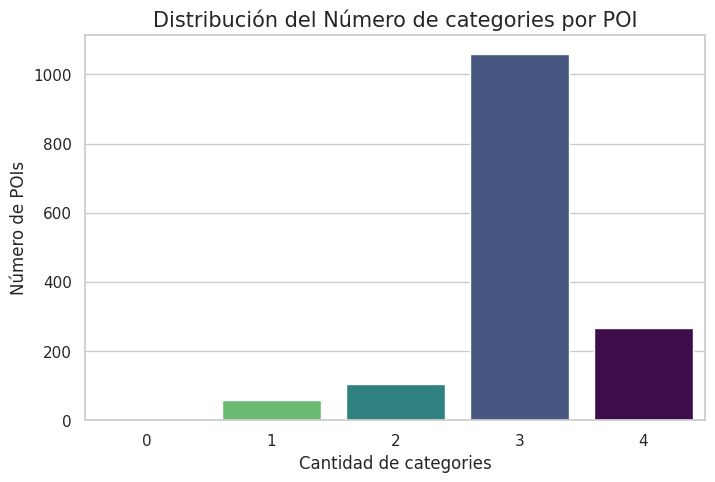


  Número total de items individuales únicos en 'categories_parsed': 12
  Los 20 items más comunes en 'categories_parsed' (y sus frecuencias):


,count
Historia,1230
Cultura,958
Arquitectura,643
Patrimonio,574
Escultura,474
Misterio,311
Ciencia,123
Ocio,73
Pintura,47
Naturaleza,43


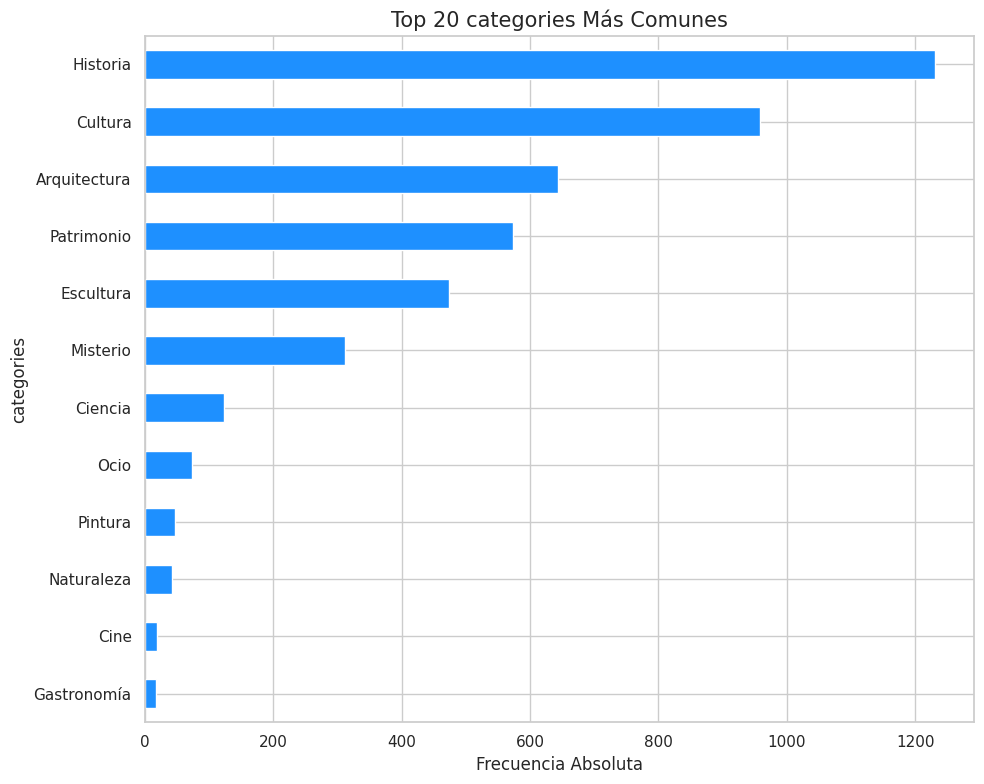


--- Análisis Detallado de la Columna de Listas: 'tags_parsed' ---
  Estadísticas del número de 'tags' por POI:


,num_tags_parsed
count,1492.000000
mean,8.920912
std,4.275762
min,0.000000
25%,5.000000
50%,10.000000
75%,13.000000
max,13.000000


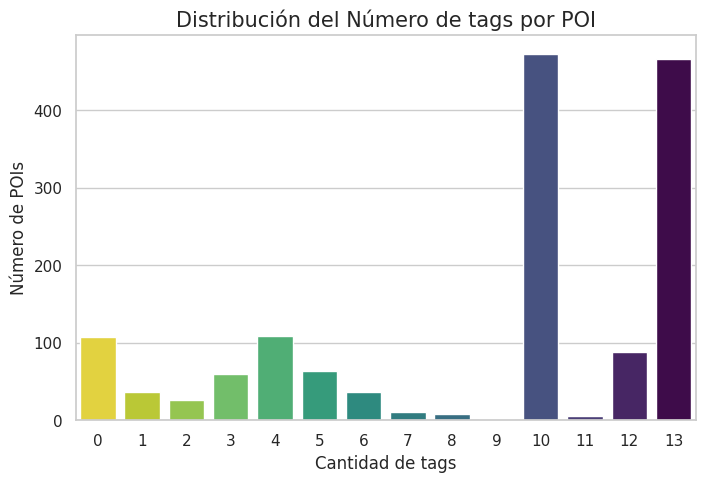


  Número total de items individuales únicos en 'tags_parsed': 2935
  Los 20 items más comunes en 'tags_parsed' (y sus frecuencias):


,count
Historia,802
Madrid,700
Cultura,583
Arquitectura,398
Patrimonio,353
Arte,329
Escultura,328
Estatua,269
Monumento,166
Naturaleza,150


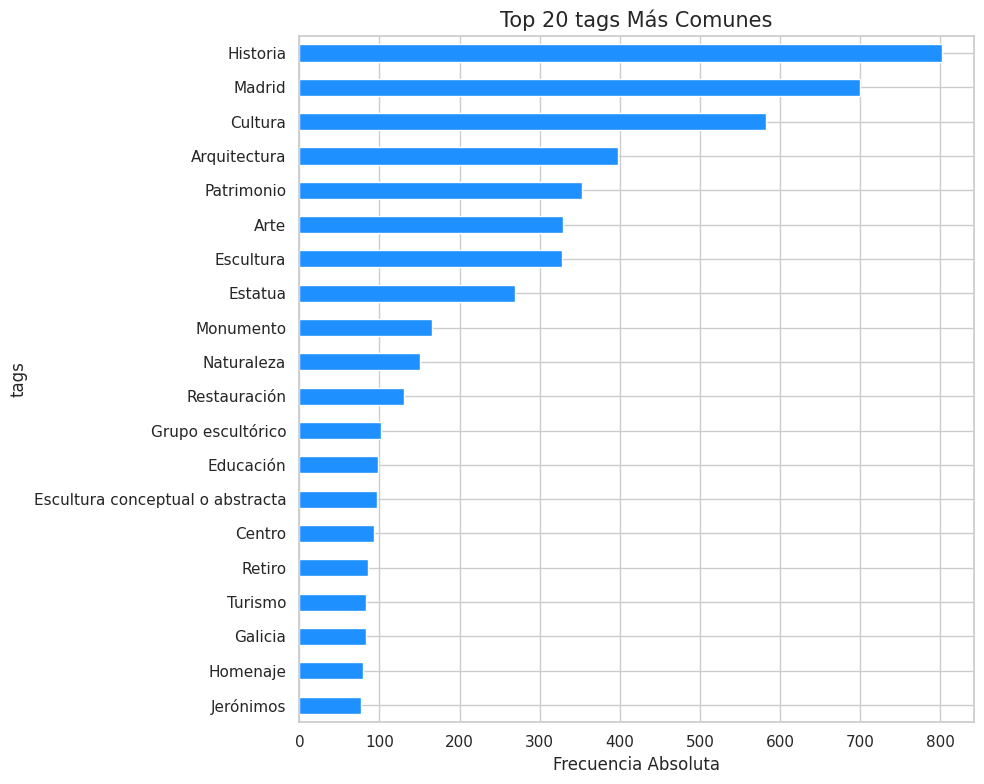

In [13]:
# --- Parsear la columna 'categories' ya que es un string que representa una lista ---
if 'categories' in df_meta.columns and not df_meta['categories'].empty:
    # Verificamos el tipo del primer elemento para confirmar que es un string necesitando parseo
    sample_category_item_type = type(df_meta['categories'].iloc[0])
    print(f"\nTipo detectado para el primer elemento de 'categories': {sample_category_item_type}")

    if isinstance(df_meta['categories'].iloc[0], str):
        print("La columna 'categories' es un string que representa una lista. Parseando a 'categories_parsed'...")
        try:
            # Aplicamos ast.literal_eval solo a los strings. Si hay otros tipos (ej. listas ya parseadas o NaNs), los deja como están.
            df_meta['categories_parsed'] = df_meta['categories'].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') and x.endswith(']') else x
            )
            print("Columna 'categories' parseada exitosamente a 'categories_parsed'.")

            # Verificar el tipo del primer elemento en la nueva columna parseada:
            if not df_meta['categories_parsed'].empty and df_meta['categories_parsed'].iloc[0] is not None:
                 print(f"  Tipo del primer elemento en 'categories_parsed' después del parseo: {type(df_meta['categories_parsed'].iloc[0])}")
                 print(f"  Ejemplo de 'categories_parsed': {df_meta['categories_parsed'].iloc[0]}")

            # Opcional: Considerar reemplazar la columna original si el parseo es exitoso y verificado
            # df_meta['categories'] = df_meta['categories_parsed']
            # df_meta.drop(columns=['categories_parsed'], inplace=True)
            # Por ahora, mantenemos 'categories_parsed' para claridad.

        except Exception as e:
            print(f"Error al parsear 'categories': {e}. Revisa el formato de los datos.")
            # Si hay error, creamos 'categories_parsed' como copia para evitar fallos en el código subsiguiente
            if 'categories_parsed' not in df_meta.columns:
                 df_meta['categories_parsed'] = df_meta['categories']
    elif isinstance(df_meta['categories'].iloc[0], list):
        print("\nLa columna 'categories' ya parece ser una lista. Simplemente se copiará a 'categories_parsed'.")
        df_meta['categories_parsed'] = df_meta['categories'] # Simplemente la copiamos para un nombre uniforme
    else:
        print(f"\nFormato inesperado para 'categories'. Tipo del primer elemento: {sample_category_item_type}. No se parseó, se copiará tal cual a 'categories_parsed'.")
        df_meta['categories_parsed'] = df_meta['categories']
else:
    print("La columna 'categories' no está disponible o está vacía.")


# --- Renombrar 'tags' a 'tags_parsed' para consistencia (ya es una lista) ---
if 'tags' in df_meta.columns:
    if 'tags_parsed' not in df_meta.columns: # Solo renombra si 'tags_parsed' no existe ya
        df_meta.rename(columns={'tags': 'tags_parsed'}, inplace=True)
        print("\nColumna 'tags' renombrada a 'tags_parsed' para consistencia.")
        if not df_meta['tags_parsed'].empty and df_meta['tags_parsed'].iloc[0] is not None:
            print(f"  Tipo del primer elemento en 'tags_parsed' (antes 'tags'): {type(df_meta['tags_parsed'].iloc[0])}")
            print(f"  Ejemplo de 'tags_parsed': {df_meta['tags_parsed'].iloc[0]}")
    elif 'tags_parsed' in df_meta.columns: # Si 'tags_parsed' ya existe (ej. de una ejecución previa) y 'tags' también, podríamos eliminar 'tags'
        if 'tags' in df_meta.columns and 'tags_parsed' in df_meta.columns and 'tags' != 'tags_parsed':
            # df_meta.drop(columns=['tags'], inplace=True) # Opcional
            print("\nLa columna 'tags_parsed' ya existía. La columna 'tags' original se mantiene o puede ser eliminada manualmente si es redundante.")
else:
    print("La columna 'tags' no se encuentra para renombrar.")


# --- Análisis de las Columnas de Listas: 'categories_parsed' y 'tags_parsed' ---
# Estas columnas ahora deberían contener listas de strings.

list_columns_to_analyze = []
if 'categories_parsed' in df_meta.columns:
    # Asegurarse de que la columna contiene listas (o manejar otros tipos si es necesario)
    if not df_meta['categories_parsed'].empty and isinstance(df_meta['categories_parsed'].iloc[0], list):
        list_columns_to_analyze.append('categories_parsed')
    else:
        print(f"Advertencia: 'categories_parsed' no parece contener listas consistentemente. Primer elemento tipo: {type(df_meta['categories_parsed'].iloc[0]) if not df_meta['categories_parsed'].empty else 'Vacío'}")


if 'tags_parsed' in df_meta.columns:
    if not df_meta['tags_parsed'].empty and isinstance(df_meta['tags_parsed'].iloc[0], list):
        list_columns_to_analyze.append('tags_parsed')
    else:
        print(f"Advertencia: 'tags_parsed' no parece contener listas consistentemente. Primer elemento tipo: {type(df_meta['tags_parsed'].iloc[0]) if not df_meta['tags_parsed'].empty else 'Vacío'}")


for col_name in list_columns_to_analyze:
    print(f"\n--- Análisis Detallado de la Columna de Listas: '{col_name}' ---")

    # Contar el número de items (categorías/tags) por POI
    # Se asegura que solo se aplica len() a las listas. Si hay NaNs o no-listas, devuelve 0.
    df_meta[f'num_{col_name}'] = df_meta[col_name].apply(lambda x: len(x) if isinstance(x, list) else 0)
    print(f"  Estadísticas del número de '{col_name.replace('_parsed', '')}' por POI:")
    display(df_meta[f'num_{col_name}'].describe())

    plt.figure(figsize=(8, 5))
    sns.countplot(x=f'num_{col_name}', data=df_meta, palette="viridis_r", hue=f'num_{col_name}', legend=False)
    plt.title(f'Distribución del Número de {col_name.replace("_parsed", "")} por POI', fontsize=15)
    plt.xlabel(f'Cantidad de {col_name.replace("_parsed", "")}', fontsize=12)
    plt.ylabel('Número de POIs', fontsize=12)
    plt.show()

    # Obtener todas las categorías/tags individuales en una sola lista ("aplanar")
    all_items_in_column = []
    # Solo procesar si la columna existe y no está vacía
    if not df_meta[col_name].dropna().empty:
        for item_list_from_poi in df_meta[col_name].dropna(): # Itera sobre cada lista de tags/categorías de cada POI
            if isinstance(item_list_from_poi, list):
                all_items_in_column.extend(item_list_from_poi) # .extend() añade todos los elementos de la lista interna
            # else: print(f"Advertencia: Elemento no lista encontrado en {col_name}: {item_list_from_poi}") # Para depuración

    if all_items_in_column:
        # Contar la frecuencia de cada categoría/tag individual
        item_counts = pd.Series(all_items_in_column).value_counts()
        print(f"\n  Número total de items individuales únicos en '{col_name}': {len(item_counts)}")
        print(f"  Los 20 items más comunes en '{col_name}' (y sus frecuencias):")
        display(item_counts.head(20))

        # Graficar los 20 más comunes
        plt.figure(figsize=(10, 8)) # Ajusta el tamaño según necesites
        item_counts.head(20).plot(kind='barh', color='dodgerblue')
        plt.title(f'Top 20 {col_name.replace("_parsed", "")} Más Comunes', fontsize=15)
        plt.xlabel('Frecuencia Absoluta', fontsize=12)
        plt.ylabel(col_name.replace("_parsed", ""), fontsize=12)
        plt.gca().invert_yaxis() # El más común arriba
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No se encontraron items individuales para analizar en '{col_name}'. Esto podría indicar que todas las listas estaban vacías o la columna está vacía.")

**Conclusiones y Próximos Pasos del EDA:**

1.   categories_parsed: Lista de strings. Baja cardinalidad (12 únicas). Apta para one-hot encoding o embeddings simples.
2.   Apta para one-hot encoding o embeddings simples.
tags_parsed: Lista de strings. Alta cardinalidad (2935 únicas). Requerirá embeddings o una técnica similar.
3. Ahora que hemos procesado y entendido las columnas de listas.podemos pasar a analizar las columnas numéricas restantes, especialmente Visits (que tenía un rango extraño) y las coordenadas locationLon/locationLat.



--- Análisis de la Columna 'Visits' (Consolidada) ---


,Visits
count,1492.000000
mean,10011.913695
std,5.421825
min,10001.000000
25%,10008.000000
50%,10011.000000
75%,10015.000000
max,10038.000000


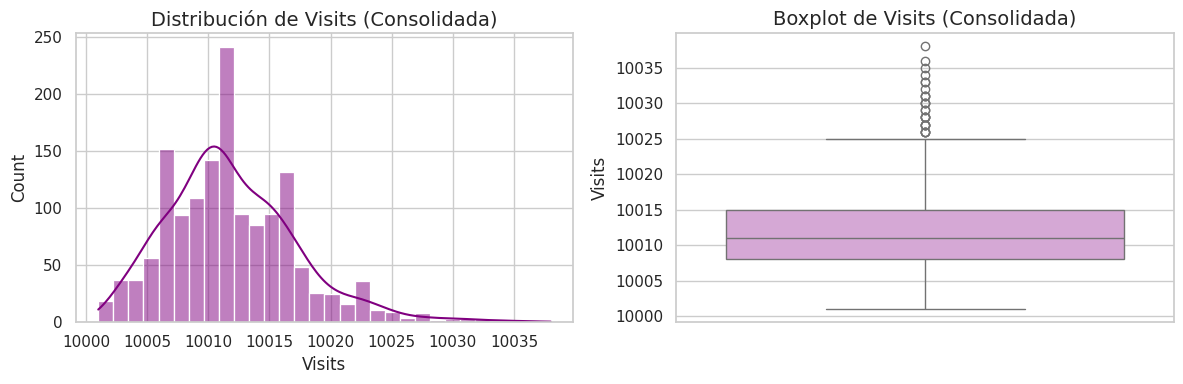


--- Análisis de Coordenadas Geográficas (Consolidado) ---

  Análisis de 'locationLon':


,locationLon
count,1492.000000
mean,-2.066378
std,20.096639
min,-121.951049
25%,-3.725086
50%,-3.700257
75%,-3.679335
max,158.333118


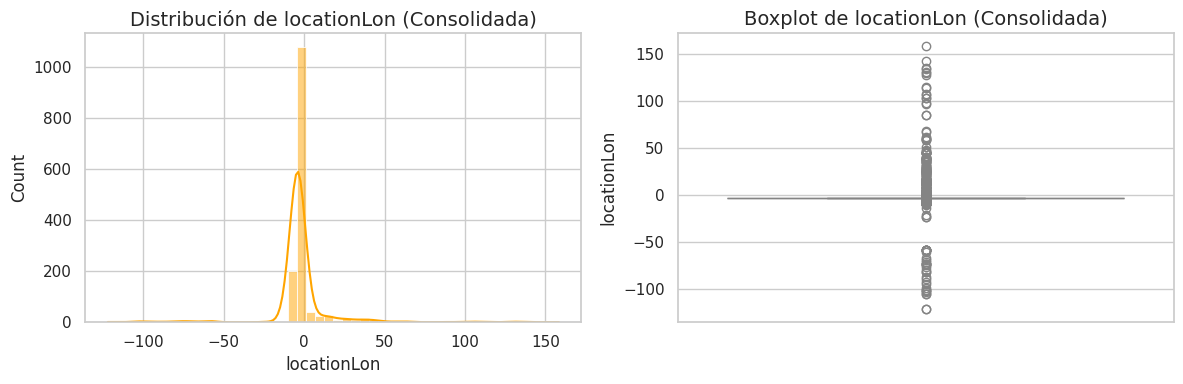


  Análisis de 'locationLat':


,locationLat
count,1492.000000
mean,39.850083
std,8.365356
min,-62.940930
25%,40.412077
50%,40.421421
75%,40.460085
max,65.706572


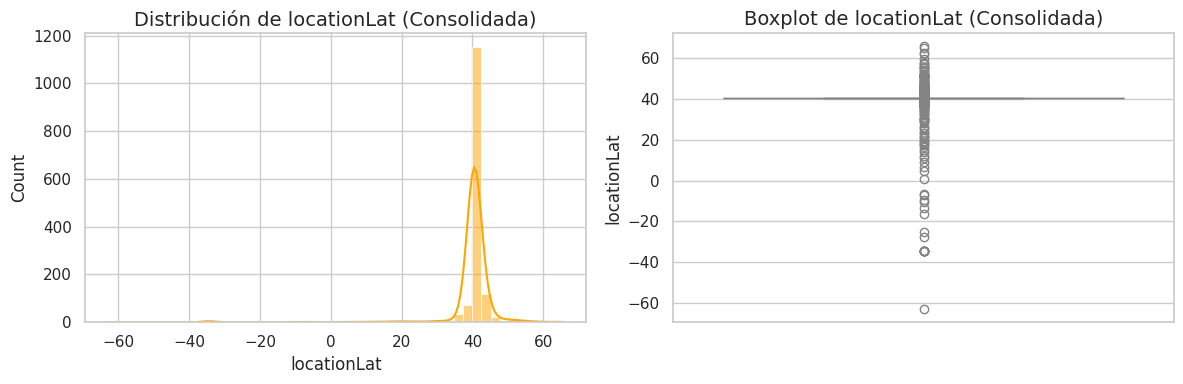

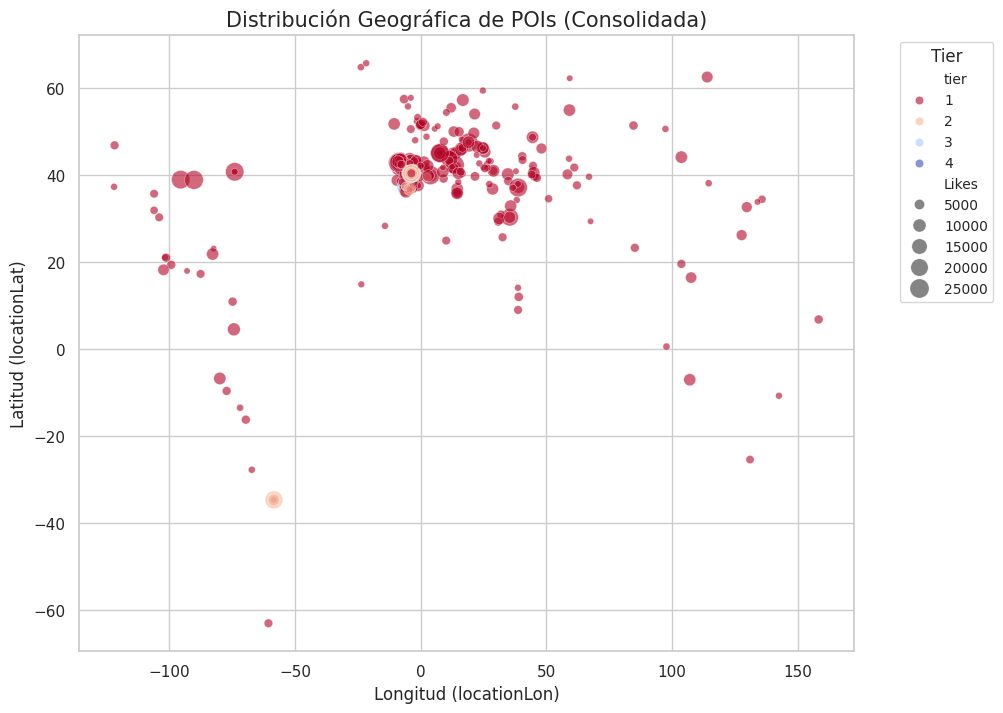


Número de POIs dentro de un bounding box aproximado de Madrid: 1032 (69.17%)
Número de POIs fuera de este bounding box: 460

--- Análisis de Otras Columnas Numéricas (Consolidado) ---

  Análisis de 'tier':


,tier
count,1492.000000
mean,1.565684
std,0.642014
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


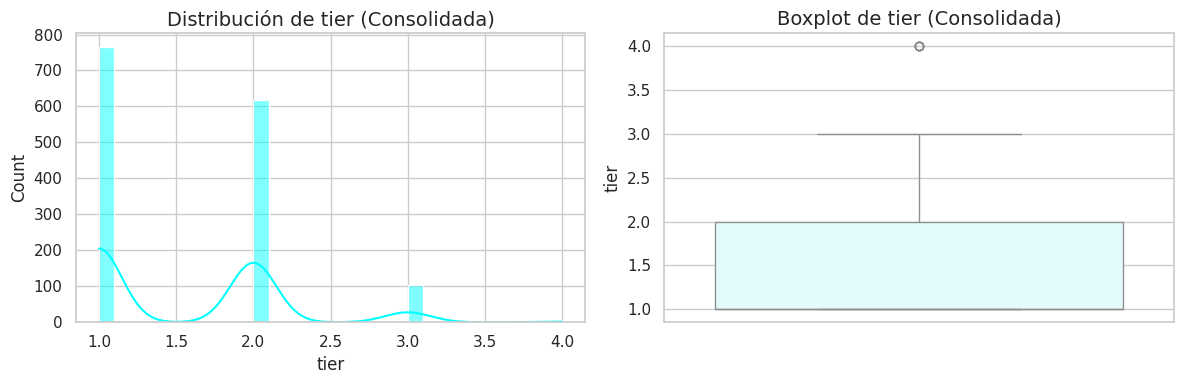


  Análisis de 'xps':


,xps
count,1492.000000
mean,740.516086
std,225.277685
min,0.000000
25%,600.000000
50%,700.000000
75%,1000.000000
max,1000.000000


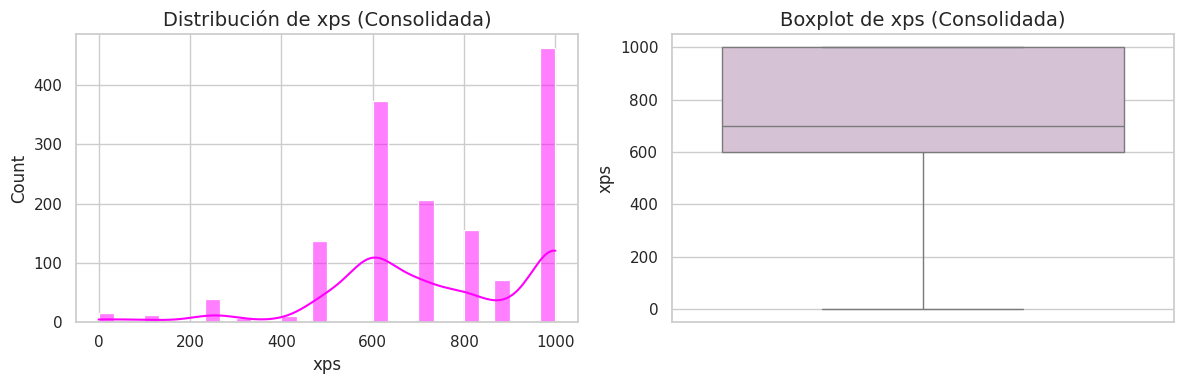


  Análisis de 'Likes':


,Likes
count,1492.000000
mean,3587.443607
std,4784.020524
min,100.000000
25%,450.000000
50%,1282.500000
75%,6467.750000
max,26425.000000


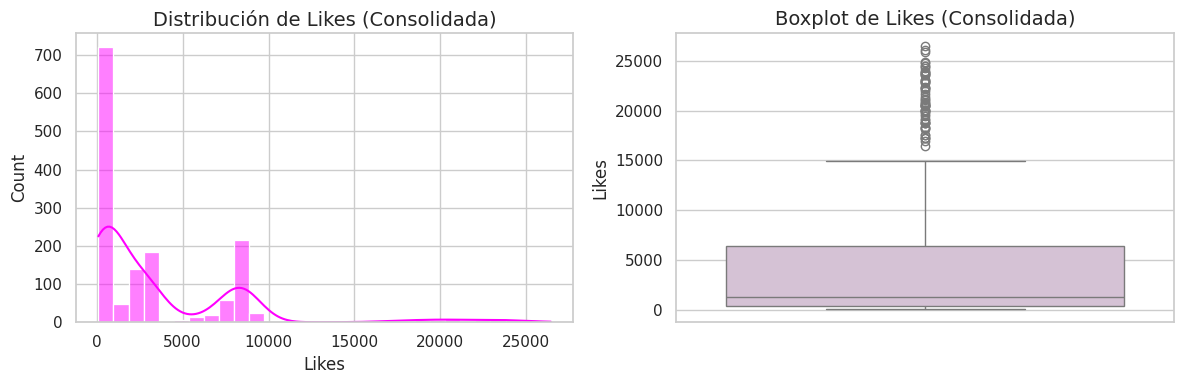


  Análisis de 'Dislikes':


,Dislikes
count,1492.000000
mean,2555.199524
std,2231.401859
min,52.000000
25%,956.250000
50%,2734.000000
75%,3424.000000
max,10999.000000


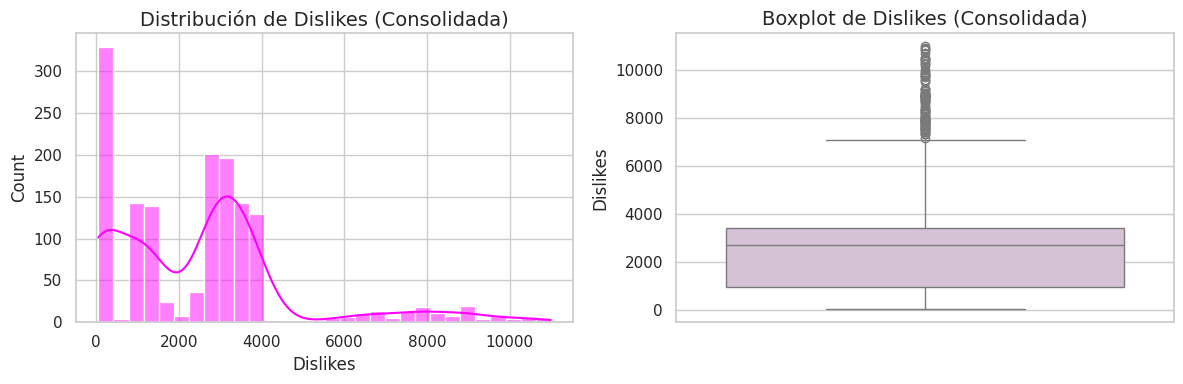


  Análisis de 'Bookmarks':


,Bookmarks
count,1492.000000
mean,964.850286
std,1448.093127
min,50.000000
25%,116.000000
50%,303.000000
75%,1264.500000
max,8157.000000


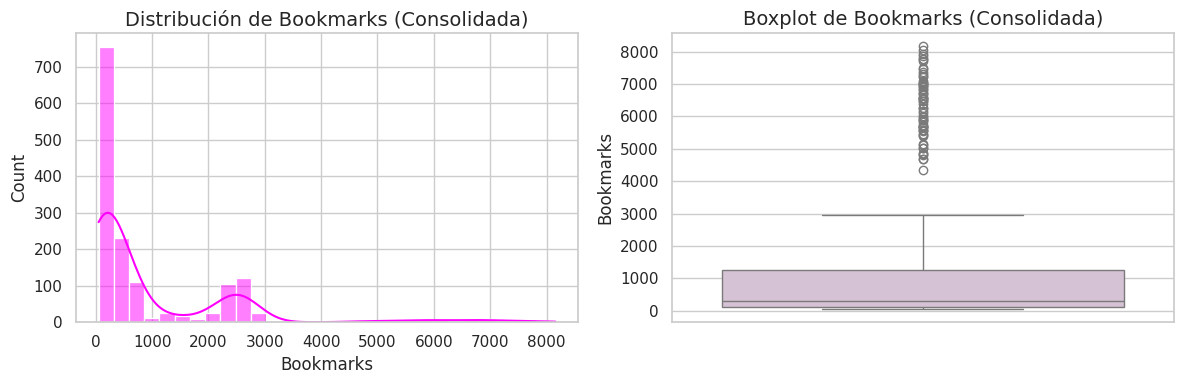

In [14]:
print("\n--- Análisis de la Columna 'Visits' (Consolidada) ---")
if 'Visits' in df_meta.columns:
    display(df_meta['Visits'].describe())
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df_meta['Visits'].dropna(), bins=30, kde=True, color='purple')
    plt.title('Distribución de Visits (Consolidada)')
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_meta['Visits'].dropna(), color='plum')
    plt.title('Boxplot de Visits (Consolidada)')
    plt.tight_layout()
    plt.show()
    # Observar si la media cambió significativamente el rango o la std.
    # La salida anterior mostraba una media de 10012.0 para el ID ejemplo.
else:
    print("Columna 'Visits' no encontrada.")

print("\n--- Análisis de Coordenadas Geográficas (Consolidado) ---")
location_cols_to_check = ['locationLon', 'locationLat']
for col_name in location_cols_to_check:
    if col_name in df_meta.columns:
        print(f"\n  Análisis de '{col_name}':")
        display(df_meta[col_name].describe())
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df_meta[col_name].dropna(), bins=50, kde=True, color='orange') # Más bins por el rango amplio
        plt.title(f'Distribución de {col_name} (Consolidada)')
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df_meta[col_name].dropna(), color='peachpuff')
        plt.title(f'Boxplot de {col_name} (Consolidada)')
        plt.tight_layout()
        plt.show()
    else:
        print(f"  Columna '{col_name}' no encontrada.")

# Scatter plot de Longitud vs Latitud (Consolidado)
if 'locationLon' in df_meta.columns and 'locationLat' in df_meta.columns:
    plt.figure(figsize=(10, 8))
    # Usamos una muestra si hay demasiados puntos para que el gráfico sea legible
    sample_df_geo_consolidated = df_meta.sample(n=min(2000, len(df_meta)), random_state=SEED) if len(df_meta) > 2000 else df_meta
    sns.scatterplot(
        x='locationLon',
        y='locationLat',
        data=sample_df_geo_consolidated.dropna(subset=['locationLon', 'locationLat']),
        hue='tier' if 'tier' in df_meta.columns else None, # Colorear por tier
        size='Likes' if 'Likes' in df_meta.columns else None, # Tamaño del punto por Likes (o Bookmarks)
        sizes=(20, 200) if 'Likes' in df_meta.columns else None,
        alpha=0.6,
        palette='coolwarm_r' if 'tier' in df_meta.columns else None
    )
    plt.title('Distribución Geográfica de POIs (Consolidada)', fontsize=15)
    plt.xlabel('Longitud (locationLon)', fontsize=12)
    plt.ylabel('Latitud (locationLat)', fontsize=12)
    if 'tier' in df_meta.columns:
        plt.legend(title='Tier', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()
    # Filtrar para un rango más "esperado" para Madrid (ejemplo) y ver cuántos POIs quedan fuera
    # Coordenadas aproximadas de Madrid: Lat ~40.4, Lon ~ -3.7
    # Definimos un bounding box generoso alrededor de Madrid
    lat_min_madrid, lat_max_madrid = 39.0, 41.5
    lon_min_madrid, lon_max_madrid = -5.0, -2.0

    pois_en_madrid_aprox = df_meta[
        (df_meta['locationLat'].between(lat_min_madrid, lat_max_madrid)) &
        (df_meta['locationLon'].between(lon_min_madrid, lon_max_madrid))
    ]
    print(f"\nNúmero de POIs dentro de un bounding box aproximado de Madrid: {len(pois_en_madrid_aprox)} ({len(pois_en_madrid_aprox)/len(df_meta)*100:.2f}%)")
    print(f"Número de POIs fuera de este bounding box: {len(df_meta) - len(pois_en_madrid_aprox)}")

# Análisis de otras métricas numéricas (tier, xps, Likes, Dislikes, Bookmarks)
# Estas ya se analizaron antes, pero ahora es sobre el dataset consolidado y con el tipo float para las de engagement.
numerical_cols_remaining = ['tier', 'xps', 'Likes', 'Dislikes', 'Bookmarks']
print("\n--- Análisis de Otras Columnas Numéricas (Consolidado) ---")
for col_name in numerical_cols_remaining:
    if col_name in df_meta.columns:
        print(f"\n  Análisis de '{col_name}':")
        display(df_meta[col_name].describe())
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df_meta[col_name].dropna(), bins=30, kde=True, color='cyan' if col_name=='tier' else 'magenta')
        plt.title(f'Distribución de {col_name} (Consolidada)')
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df_meta[col_name].dropna(), color='lightcyan' if col_name=='tier' else 'thistle')
        plt.title(f'Boxplot de {col_name} (Consolidada)')
        plt.tight_layout()
        plt.show()
    else:
        print(f"  Columna '{col_name}' no encontrada.")

Conclusión: Incluso después de promediar durante la consolidación, la columna Visits mantiene un rango extremadamente estrecho y una desviación estándar muy pequeña. Esto refuerza fuertemente la sospecha de que esta columna, en su forma actual, podría no ser muy útil para diferenciar el engagement entre POIs. Si todos los POIs tienen un número de visitas tan similar, esta característica no aportará mucha información al modelo para clasificar el engagement como alto o bajo.

Resumen de Hallazgos y Próximos Pasos del EDA de Metadatos:

- id: Limpio y único.
- Valores Faltantes: No hay.
- categories_parsed: Lista de strings, baja cardinalidad (12). Lista para usar.
- tags_parsed: Lista de strings, alta cardinalidad (2935). Requerirá embeddings.
- Visits: Rango muy estrecho, probablemente poco útil como predictor directo o como componente principal de la métrica de engagement si se usa en su escala actual.
- Ubicación (locationLon, locationLat): Dataset con POIs globales, pero con una fuerte concentración (aprox. 70%) en la zona de Madrid. Necesitarás decidir cómo manejar los POIs de fuera.
- Likes, Bookmarks: Parecen las métricas de engagement más prometedoras debido a su dispersión y rangos. Dislikes también tiene variación.
- tier, xps: Parecen consistentes.





--- Verificación de Rutas de Imágenes ---
Total de POIs: 1492
Imágenes encontradas: 1492 (100.00%)
¡Genial! Todas las imágenes fueron encontradas.
  Ejemplo de ruta construida: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/002b3c1f-37f0-4d36-84d4-2d7132f83fe7/main.jpg

--- Mostrando 5 Imágenes de Muestra ---


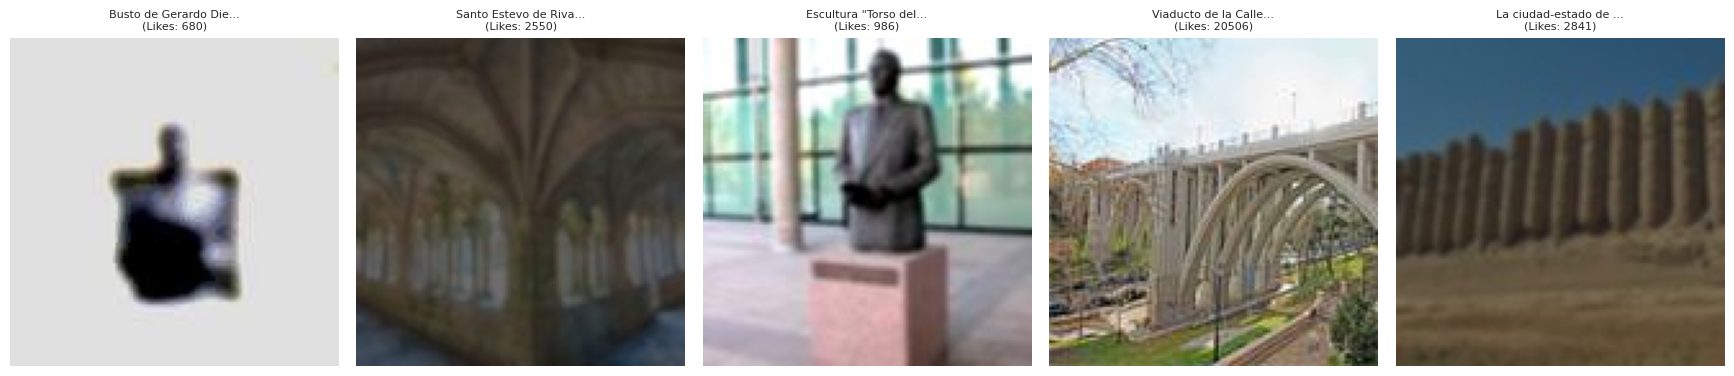

In [15]:
# --- PASO 1: Construir la ruta completa a cada imagen ---
df_meta['full_image_path'] = df_meta['main_image_path'].apply(
    lambda rel_path: os.path.join(DATA_PATH, str(rel_path)) if pd.notnull(rel_path) else None
)

# --- PASO 2: Verificar cuáles de esas rutas existen realmente ---
# Creamos una columna booleana 'image_exists'.
df_meta['image_exists'] = df_meta['full_image_path'].apply(
    lambda full_path: os.path.exists(full_path) if pd.notnull(full_path) else False
)

# --- PASO 3: Informar sobre la validez de las rutas ---
num_total_pois = len(df_meta)
num_valid_image_paths = df_meta['image_exists'].sum()
percentage_valid_paths = (num_valid_image_paths / num_total_pois) * 100

print(f"\n--- Verificación de Rutas de Imágenes ---")
print(f"Total de POIs: {num_total_pois}")
print(f"Imágenes encontradas: {num_valid_image_paths} ({percentage_valid_paths:.2f}%)")

if percentage_valid_paths == 100:
    print("¡Genial! Todas las imágenes fueron encontradas.")
    if not df_meta.empty: # Imprimir un ejemplo si el DataFrame no está vacío
        print(f"  Ejemplo de ruta construida: {df_meta['full_image_path'].iloc[0]}")
elif percentage_valid_paths == 0:
    print("¡ALERTA! No se encontró NINGUNA imagen. Revisa la lógica de rutas o la ubicación de los archivos.")
    if not df_meta.empty:
        print(f"  Ejemplo de ruta fallida: {df_meta['full_image_path'].iloc[0]}")
else: # Algunas encontradas, otras no
    print("¡Atención! Algunas imágenes no fueron encontradas.")
    print(f"  POIs con imágenes no encontradas (ejemplos):")
    display(df_meta[~df_meta['image_exists']][['id', 'main_image_path']].head())


# --- PASO 4: Mostrar una muestra de las imágenes encontradas ---
# Filtramos el DataFrame para quedarnos solo con las filas donde la imagen existe.
df_imagenes_encontradas = df_meta[df_meta['image_exists']]

if not df_imagenes_encontradas.empty:
    num_imagenes_a_mostrar = min(5, len(df_imagenes_encontradas)) # Mostrar hasta 5
    # Tomamos una muestra aleatoria para variar las imágenes en cada ejecución (o usa SEED para consistencia)
    muestra_imagenes = df_imagenes_encontradas.sample(n=num_imagenes_a_mostrar, random_state=SEED if 'SEED' in locals() else None)

    print(f"\n--- Mostrando {num_imagenes_a_mostrar} Imágenes de Muestra ---")

    # Configuración de la figura para mostrar imágenes en una fila
    fig_ancho_por_imagen = 3.5 # Pulgadas
    fig_alto_total = 4       # Pulgadas
    plt.figure(figsize=(num_imagenes_a_mostrar * fig_ancho_por_imagen, fig_alto_total))

    for i, (idx, fila) in enumerate(muestra_imagenes.iterrows()):
        try:
            img = Image.open(fila['full_image_path'])
            ax = plt.subplot(1, num_imagenes_a_mostrar, i + 1) # 1 fila, N columnas, i-ésima imagen
            ax.imshow(img)
            # Título conciso
            titulo = f"{str(fila['name'])[:20]}...\n(Likes: {fila['Likes']:.0f})"
            ax.set_title(titulo, fontsize=8)
            ax.axis('off') # No mostrar ejes numerados
        except Exception as e:
            print(f"Error al mostrar imagen {fila['full_image_path']}: {e}")

    plt.tight_layout() # Ajusta los subplots para que quepan bien
    plt.show()
else:
    print("\nNo hay imágenes válidas para mostrar.")

Ahora que sé que puedo cargar las imágenes, quiero entender un poco más sobre ellas, específicamente sus tamaños (dimensiones) y sus modos de color. Esta información me será muy útil cuando prepare las imágenes para mi modelo de Deep Learning.

Como dice el PDF, uno de los pasos de preprocesamiento será el "redimensionamiento a dimensiones uniformes", así que necesito saber qué tan variadas son ahora


--- Análisis de Propiedades de las Imágenes (Dimensiones, Modo de Color) ---
Voy a analizar las propiedades de 200 imágenes de muestra...

  Mis Estadísticas de las Dimensiones de las Imágenes (Muestra):


,count,mean,std,min,25%,50%,75%,max
width,200.0,128.0,0.0,128.0,128.0,128.0,128.0,128.0
height,200.0,128.0,0.0,128.0,128.0,128.0,128.0,128.0


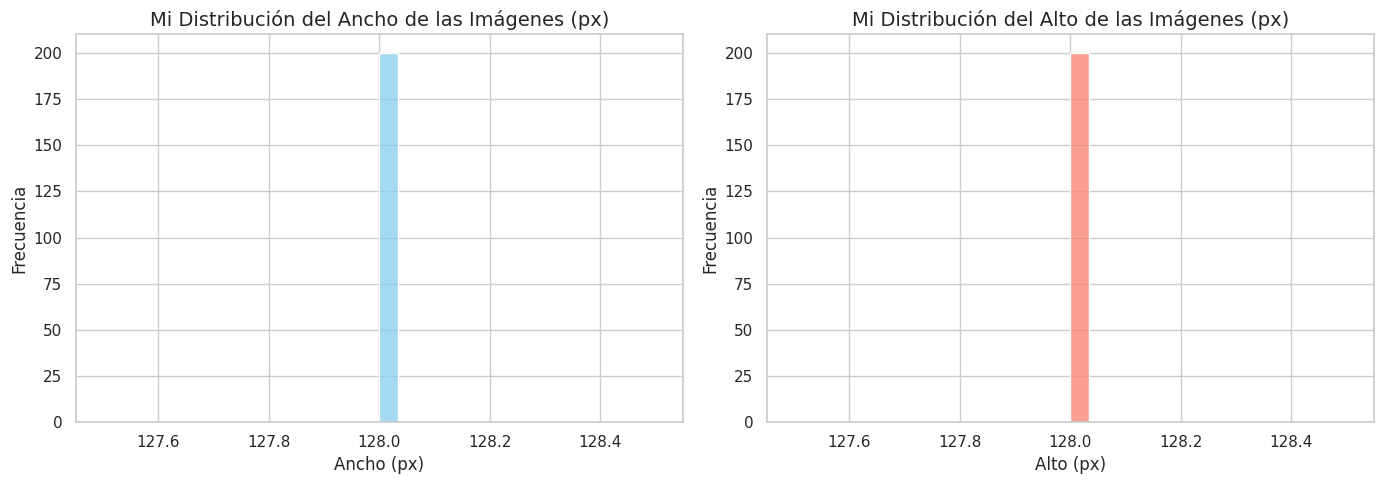

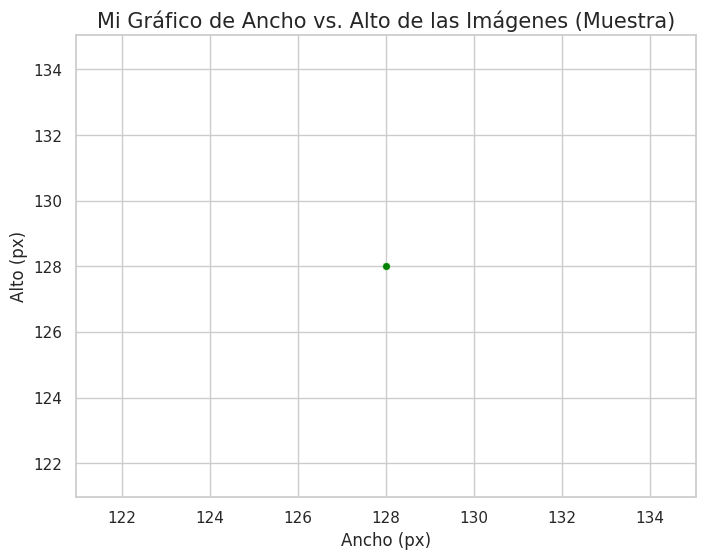


  Mis Modos de Color de las Imágenes (Muestra):


,count
RGB,200


<ipython-input-16-ad34f84d34a0>:86: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


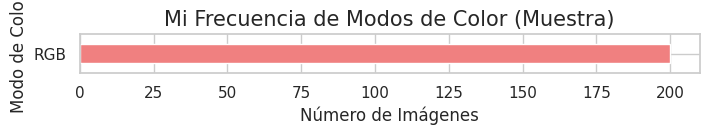

In [16]:
print("\n--- Análisis de Propiedades de las Imágenes (Dimensiones, Modo de Color) ---")

df_with_valid_images = df_meta[df_meta['image_exists']].copy()

# Voy a guardar las dimensiones y modos de color en estas listas
image_dimensions_list = []
image_modes_list = []
# Y si alguna imagen me da problemas, la registraré aquí
problematic_images_for_props = []

# Decido analizar propiedades de una muestra para que sea rápido,
# pero si tuviera pocas imágenes, podría analizarlas todas.
# df_with_valid_images ya contiene solo las filas con imágenes que existen.
num_images_to_analyze_props = min(200, len(df_with_valid_images)) # Analizaré hasta 200 imágenes

if not df_with_valid_images.empty and num_images_to_analyze_props > 0:
    # Tomo mi muestra aleatoria
    sample_images_for_props_df = df_with_valid_images.sample(n=num_images_to_analyze_props, random_state=SEED if 'SEED' in locals() else None)
    print(f"Voy a analizar las propiedades de {len(sample_images_for_props_df)} imágenes de muestra...")

    for img_path in sample_images_for_props_df['full_image_path']:
        try:
            # Abro cada imagen usando un bloque 'with' para asegurar que se cierre bien
            with Image.open(img_path) as img:
                image_dimensions_list.append(img.size)
                image_modes_list.append(img.mode)
        except Exception as e:
            print(f"Tuve un error al abrir o procesar la imagen {img_path} para sus propiedades: {e}")
            problematic_images_for_props.append(img_path)

    if problematic_images_for_props:
        print(f"\nEncontré {len(problematic_images_for_props)} imágenes problemáticas que no pude procesar para sus propiedades.")
        # print("Ejemplos de estas imágenes problemáticas:", problematic_images_for_props[:5])


    # --- Ahora analizo las Dimensiones ---
    if image_dimensions_list:
        # Convierto mi lista de dimensiones a un DataFrame para facilitar el análisis
        df_image_dims = pd.DataFrame(image_dimensions_list, columns=['width', 'height'])
        print("\n  Mis Estadísticas de las Dimensiones de las Imágenes (Muestra):")
        display(df_image_dims.describe().T) # El .T es para transponer y leerlo mejor

        # Quiero ver la distribución del ancho y alto con histogramas
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df_image_dims['width'], bins=30, kde=False, color='skyblue')
        plt.title('Mi Distribución del Ancho de las Imágenes (px)', fontsize=14)
        plt.xlabel('Ancho (px)', fontsize=12)
        plt.ylabel('Frecuencia', fontsize=12)

        plt.subplot(1, 2, 2)
        sns.histplot(df_image_dims['height'], bins=30, kde=False, color='salmon')
        plt.title('Mi Distribución del Alto de las Imágenes (px)', fontsize=14)
        plt.xlabel('Alto (px)', fontsize=12)
        plt.ylabel('Frecuencia', fontsize=12)

        plt.tight_layout()
        plt.show()

        # También quiero ver la relación entre ancho y alto con un scatter plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='width', y='height', data=df_image_dims, alpha=0.5, s=30, color='green')
        plt.title('Mi Gráfico de Ancho vs. Alto de las Imágenes (Muestra)', fontsize=15)
        plt.xlabel('Ancho (px)', fontsize=12)
        plt.ylabel('Alto (px)', fontsize=12)
        plt.grid(True)
        plt.show()

    else:
        print("No pude extraer dimensiones de las imágenes.")

    # --- Y ahora analizo los Modos de Color ---
    if image_modes_list:
        print("\n  Mis Modos de Color de las Imágenes (Muestra):")
        # Cuento cuántas veces aparece cada modo de color
        mode_counts = pd.Series(image_modes_list).value_counts()
        display(mode_counts)

        # Y lo visualizo en un gráfico de barras
        plt.figure(figsize=(8, len(mode_counts) * 0.5 if len(mode_counts) > 0 else 4))
        mode_counts.plot(kind='barh', color='lightcoral')
        plt.title('Mi Frecuencia de Modos de Color (Muestra)', fontsize=15)
        plt.xlabel('Número de Imágenes', fontsize=12)
        plt.ylabel('Modo de Color', fontsize=12)
        plt.gca().invert_yaxis() # Para que el más común quede arriba
        plt.tight_layout()
        plt.show()
    else:
        print("No pude extraer los modos de color de las imágenes.")

else:
    print("No tengo imágenes válidas en 'df_with_valid_images' para analizar sus propiedades.")

# Creación de la Variable Objetivo (Métrica de Engagement Binaria)


--- Paso 5: Creando mi Variable Objetivo (Métrica de Engagement Binaria) ---

  Después de la transformación logarítmica (primeras filas):


,Likes,Bookmarks,Likes_log,Bookmarks_log
0,865.0,118.0,6.763885,4.779123
1,8384.0,2275.0,9.034200,7.730175
2,8359.0,2151.0,9.031214,7.674153



  Después del escalado Min-Max (primeras filas):


,Likes,Bookmarks,Likes_log,Bookmarks_log
0,865.0,118.0,0.385984,0.166958
1,8384.0,2275.0,0.793801,0.748454
2,8359.0,2151.0,0.793265,0.737415



  Después de calcular 'engagement_score' (primeras filas de df_meta):


,id,Likes,Bookmarks,engagement_score
0,002b3c1f-37f0-4d36-84d4-2d7132f83fe7,865.0,118.0,0.276471
1,005fe23a-7f9e-4a57-a24a-1e9a6f1c1702,8384.0,2275.0,0.771128
2,00761a42-1b02-42f3-b2b2-211ffd985118,8359.0,2151.0,0.765340



  Estadísticas de mi 'engagement_score':


,engagement_score
count,1492.000000
mean,0.439034
std,0.256905
min,0.013298
25%,0.220146
50%,0.396905
75%,0.698829
max,0.987689


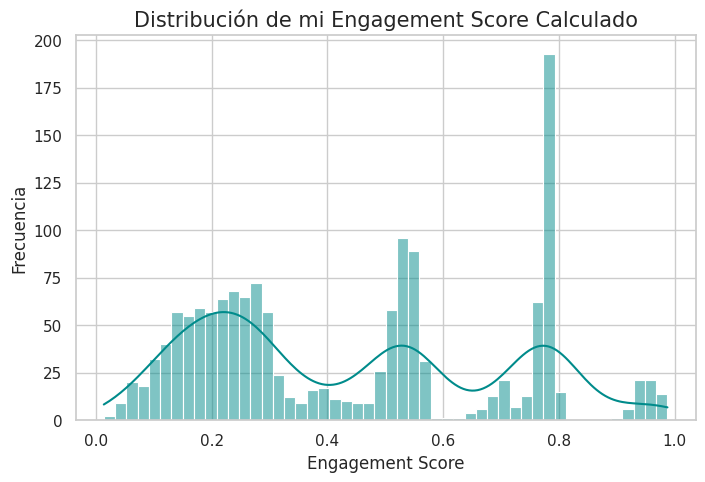


  El umbral (mediana) que usaré para binarizar el engagement_score es: 0.3969

  Distribución de mi variable objetivo 'target_engagement':


,proportion
target_engagement,
0,50.0
1,50.0


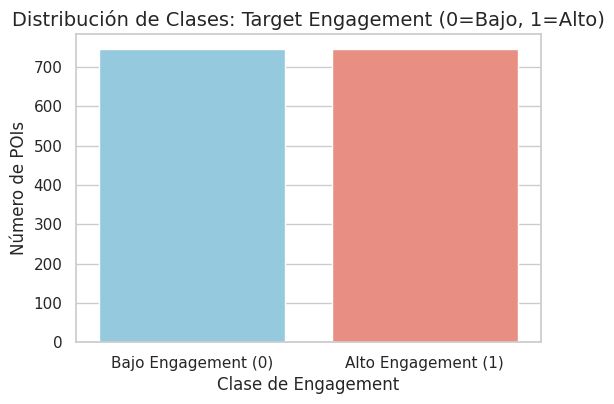

Mis clases para 'target_engagement' están razonablemente balanceadas.


In [17]:
print("\n--- Paso 5: Creando mi Variable Objetivo (Métrica de Engagement Binaria) ---")

# Mis métricas base para el engagement positivo. Decido excluir 'Visits' por su rango estrecho
# y 'Dislikes' porque no representa necesariamente "éxito". ¡Tú puedes justificar otra elección!
metrics_for_score = ['Likes', 'Bookmarks']
df_eng = df_meta[metrics_for_score].copy() # Trabajo sobre una copia

# 1. Transformación Logarítmica (np.log1p suma 1 antes del log para manejar ceros, aunque aquí no tenemos ceros)
# Dado que tus mínimos son >0, un log simple también podría funcionar, pero log1p es más robusto.
for col in metrics_for_score:
    df_eng[f'{col}_log'] = np.log1p(df_eng[col])

print("\n  Después de la transformación logarítmica (primeras filas):")
display(df_eng.head(3))

# 2. Escalado Min-Max a [0, 1]
# Preparo mi scaler
min_max_scaler = MinMaxScaler()
cols_to_scale = [f'{col}_log' for col in metrics_for_score]
df_eng[cols_to_scale] = min_max_scaler.fit_transform(df_eng[cols_to_scale])

print("\n  Después del escalado Min-Max (primeras filas):")
display(df_eng.head(3))

# 3. Combinación para crear un 'engagement_score'
# Empezaré con un promedio simple de las métricas log-transformadas y escaladas.
# Podrías experimentar con pesos diferentes si tienes alguna razón para ello.
df_eng['engagement_score'] = df_eng[cols_to_scale].mean(axis=1)
df_meta['engagement_score'] = df_eng['engagement_score'] # Añado el score a mi DataFrame principal

print("\n  Después de calcular 'engagement_score' (primeras filas de df_meta):")
display(df_meta[['id', 'Likes', 'Bookmarks', 'engagement_score']].head(3))

print("\n  Estadísticas de mi 'engagement_score':")
display(df_meta['engagement_score'].describe())

# Visualizo la distribución de mi 'engagement_score'
plt.figure(figsize=(8,5))
sns.histplot(df_meta['engagement_score'], bins=50, kde=True, color='darkcyan')
plt.title('Distribución de mi Engagement Score Calculado', fontsize=15)
plt.xlabel('Engagement Score', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

# 4. Binarización para crear la variable objetivo 'target_engagement'
# Usaré la mediana como umbral para intentar tener clases balanceadas.
# Podrías elegir otro umbral (ej. quantil 0.6 o 0.7 para definir "alto" de forma más estricta).
engagement_threshold = df_meta['engagement_score'].median()
print(f"\n  El umbral (mediana) que usaré para binarizar el engagement_score es: {engagement_threshold:.4f}")

df_meta['target_engagement'] = (df_meta['engagement_score'] >= engagement_threshold).astype(int) # 1 para Alto, 0 para Bajo

print("\n  Distribución de mi variable objetivo 'target_engagement':")
# value_counts(normalize=True) me da el porcentaje de cada clase.
target_distribution = df_meta['target_engagement'].value_counts(normalize=True) * 100
display(target_distribution)

plt.figure(figsize=(6,4))
sns.countplot(x='target_engagement', data=df_meta, palette={0: "skyblue", 1: "salmon"}, hue='target_engagement', legend=False)
plt.title('Distribución de Clases: Target Engagement (0=Bajo, 1=Alto)', fontsize=14)
plt.xlabel('Clase de Engagement', fontsize=12)
plt.ylabel('Número de POIs', fontsize=12)
plt.xticks([0, 1], ['Bajo Engagement (0)', 'Alto Engagement (1)'])
plt.show()

if abs(target_distribution.get(0, 0) - target_distribution.get(1, 0)) > 20: # Si la diferencia es > 20%
    print("¡Atención! Mis clases están algo desbalanceadas. Podría necesitar considerarlo en el entrenamiento o evaluación.")
else:
    print("Mis clases para 'target_engagement' están razonablemente balanceadas.")

# Fase 1: Preparación y Análisis de Datos - Resumen de Hallazgos

## 1. Carga Inicial de Metadatos
- El archivo `poi_dataset.csv` se cargó exitosamente en el DataFrame `df_meta`.
- Dimensiones iniciales: 1569 filas (POIs) y 14 columnas.
- Una inspección inicial (`df_meta.info()`) sugirió que no había valores faltantes en ninguna columna.

## 2. Limpieza de Datos: IDs Duplicados
- **Observación Crítica:** Se detectó que la columna `id` no era única (1492 IDs únicos para 1569 filas). El ID más frecuente aparecía 7 veces.
- **Análisis de Duplicados:** Se encontró que las filas con el mismo `id` eran casi idénticas, diferenciándose principalmente en la columna `tags` y ligeramente en las métricas de engagement.
- **Estrategia de Consolidación:**
    - Se agruparon las filas por `id`.
    - Columnas consistentes (`name`, `shortDescription`, `categories`, `tier`, `locationLon`, `locationLat`, `main_image_path`) tomaron el `'first'` valor.
    - `xps` y las métricas de engagement (`Visits`, `Likes`, `Dislikes`, `Bookmarks`) se promediaron (`'mean'`).
    - `tags` se consolidaron combinando todas las tags únicas asociadas a un `id` en una sola lista, después de parsear los strings de listas con `ast.literal_eval`.
- **Resultado:** El DataFrame principal (`df_meta`) fue actualizado con los datos consolidados, resultando en **1492 filas**, donde cada `id` es ahora único.

## 3. Confirmación de Valores Faltantes (Post-Consolidación)
- Se confirmó explícitamente que el DataFrame consolidado `df_meta` **no contiene valores faltantes** en ninguna columna.

## 4. Análisis Exploratorio de Datos (EDA) - Metadatos (Post-Consolidación)

### 4.1. `categories_parsed` y `tags_parsed`
- **`categories`:**
    - Parseada de string a lista de Python (nueva columna `categories_parsed`).
    - **Baja Cardinalidad:** Se encontraron **12 categorías únicas** en total (ej. 'Historia', 'Cultura', 'Arquitectura').
    - La mayoría de los POIs tienen 3 categorías (media ~3, máx 4, min 0).
    - *Implicación:* Apta para one-hot encoding o embeddings simples.
- **`tags_parsed`:** (Columna `tags` original renombrada y ya parseada a lista durante la consolidación)
    - **Alta Cardinalidad:** Se encontraron **2935 tags únicos** en total (ej. 'Historia', 'Madrid', 'Arte').
    - En promedio, un POI tiene ~9 tags (mediana 10, máx 13, min 0).
    - *Implicación:* Requerirá una estrategia de encoding más avanzada, como embeddings, debido a la alta cardinalidad, tal como advierte el PDF.

### 4.2. Métricas de Engagement (Raw) y `Visits`
- **`Visits`:** Mantiene un rango extremadamente estrecho (10001-10038) y una desviación estándar muy pequeña incluso después de promediar.
    - *Implicación:* Probablemente no sea una característica muy discriminativa para el engagement.
- **`Likes`, `Bookmarks`, `Dislikes`:** Muestran buena dispersión y rangos amplios, con distribuciones sesgadas a la derecha. `Likes` y `Bookmarks` parecen ser buenos indicadores de engagement positivo.

### 4.3. Ubicación (`locationLon`, `locationLat`)
- Las coordenadas cubren un rango geográfico global.
- Sin embargo, aproximadamente el **69.17% (1032 POIs)** se concentran dentro de un *bounding box* aproximado para la zona de Madrid.
- Los POIs restantes (460) están fuera de esta zona.
- *Implicación:* Se debe considerar cómo tratar los POIs fuera de la zona de Madrid, especialmente si se usan características como `distrito` o `barrio` (que no estaban presentes en el dataset).
- **`distrito` y `barrio`**: Estas columnas, mencionadas en el PDF, **no se encontraron** en el archivo CSV provisto.

### 4.4. Otras Columnas
- **`tier`**: Valores entre 1 y 4, con la mayoría en tier 1.
- **`xps`**: Valores entre 0 y 1000, con una distribución razonable.

## 5. Análisis Exploratorio de Datos (EDA) - Imágenes
- **Rutas de Imágenes:** Se corrigió la lógica de construcción de rutas y se verificó que el **100% de los 1492 POIs tienen una ruta de imagen válida** y el archivo correspondiente existe.
    - El formato de ruta es `.../data/data_main/POI_ID/main.jpg`.
- **Propiedades de las Imágenes (basado en una muestra de 200 imágenes):**
    - **Dimensiones:** Todas las imágenes de la muestra tienen dimensiones uniformes de **128x128 píxeles**.
    - **Modo de Color:** Todas las imágenes de la muestra están en modo **RGB**.
- *Implicación:* El preprocesamiento de imágenes se simplifica enormemente. El redimensionamiento a dimensiones uniformes y la conversión de modo de color ya están hechos (alineado con el comentario del PDF sobre imágenes "específicamente procesadas"). Se necesitará normalización de píxeles.

## 6. Creación de la Variable Objetivo (`target_engagement`)
- **Estrategia Implementada:**
    1. Se seleccionaron `Likes` y `Bookmarks` como indicadores de engagement positivo.
    2. Se aplicó transformación logarítmica (`np.log1p`) a estas métricas.
    3. Se escalaron las métricas transformadas al rango [0,1] usando `MinMaxScaler`.
    4. Se creó un `engagement_score` como el promedio de estas dos métricas procesadas.
    5. El `engagement_score` (rango [~0.013, ~0.988], mediana ~0.3969) se binarizó usando su **mediana** como umbral.
- **Resultado:**
    - La variable objetivo `target_engagement` (0 para Bajo Engagement, 1 para Alto Engagement) fue creada.
    - Las clases resultaron **perfectamente balanceadas (50% para la clase 0 y 50% para la clase 1)**.
- *Implicación:* Se cuenta con una variable objetivo binaria y balanceada, ideal para entrenar un modelo de clasificación.

## Conclusión de la Fase
El DataFrame `df_meta` está ahora limpio, consolidado (1492 POIs únicos), y enriquecido con características analizadas y una variable objetivo `target_engagement` lista para la fase de diseño y entrenamiento del modelo.

## **Arquitectura del Modelo**

In [18]:
# --- PASO 6.1 y 6.2 (parcial): Preparar Columnas de Metadatos ---

# Selecciono mis columnas numéricas para escalar
numerical_features = ['tier', 'locationLon', 'locationLat', 'xps', 'num_categories_parsed', 'num_tags_parsed']
# Selecciono mis columnas que contienen listas de strings para embeddings/tokenización
# (categories_parsed podría ser one-hot encoded si lo prefieres, dado su baja cardinalidad)
text_list_features = ['categories_parsed', 'tags_parsed']

print("Mis características numéricas seleccionadas:", numerical_features)
print("Mis características de lista de texto seleccionadas:", text_list_features)

# Copio el DataFrame para no modificar el original directamente en este paso
df_processed = df_meta.copy()

# --- Escalado de Características Numéricas ---
# Voy a usar StandardScaler.
scaler = StandardScaler()
df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])
print("\nCaracterísticas numéricas escaladas (primeras 3 filas):")
display(df_processed[numerical_features].head(3))

# --- Tokenización y Padding para 'categories_parsed' y 'tags_parsed' ---
# Para 'categories_parsed' (baja cardinalidad: 12 únicas)
# Podríamos hacer one-hot encoding, pero vamos a prepararla para embeddings también por consistencia y flexibilidad
# Un vocabulario pequeño para categorías.
tokenizer_categories = Tokenizer(oov_token="<unk>") # oov_token maneja palabras fuera de vocabulario
# Ajusto el tokenizer solo en las listas de categorías (asegurándome de que sean listas de strings)
df_processed['categories_parsed_str'] = df_processed['categories_parsed'].apply(lambda x: [str(item) for item in x] if isinstance(x, list) else [])
tokenizer_categories.fit_on_texts(df_processed['categories_parsed_str'])
sequences_categories = tokenizer_categories.texts_to_sequences(df_processed['categories_parsed_str'])

# Decido un MAX_CATEGORIES_PER_POI. Vimos que el máximo era 4. Usaré 5 por si acaso.
MAX_CATEGORIES_PER_POI = 5
data_categories = pad_sequences(sequences_categories, maxlen=MAX_CATEGORIES_PER_POI, padding='post', truncating='post')
vocab_size_categories = len(tokenizer_categories.word_index) + 1 # +1 para el índice 0 (padding)
print(f"\n'categories_parsed' procesadas: Vocabulario de {vocab_size_categories} categorías, forma del dato: {data_categories.shape}")
# print("Índice de palabras para categorías:", tokenizer_categories.word_index)

# Para 'tags_parsed' (alta cardinalidad: 2935 únicas)
# Limitare el vocabulario para no tener una capa de embedding gigantesca.

MAX_TAGS_VOCAB = 1000 # Decido tomar los 1000 tags más frecuentes.
tokenizer_tags = Tokenizer(num_words=MAX_TAGS_VOCAB, oov_token="<unk>")
df_processed['tags_parsed_str'] = df_processed['tags_parsed'].apply(lambda x: [str(item) for item in x] if isinstance(x, list) else [])
tokenizer_tags.fit_on_texts(df_processed['tags_parsed_str'])
sequences_tags = tokenizer_tags.texts_to_sequences(df_processed['tags_parsed_str'])

# Decido un MAX_TAGS_PER_POI. Vi que el máximo era 13. Usaré 15.
MAX_TAGS_PER_POI = 15
data_tags = pad_sequences(sequences_tags, maxlen=MAX_TAGS_PER_POI, padding='post', truncating='post')
vocab_size_tags = min(MAX_TAGS_VOCAB, len(tokenizer_tags.word_index) + 1)
print(f"'tags_parsed' procesadas: Usando un vocabulario de hasta {vocab_size_tags} tags, forma del dato: {data_tags.shape}")


# Concatenamos las características numéricas procesadas con las secuencias de categorías y tags.
# Por ahora, tenemos:
# - df_processed[numerical_features].values (para las numéricas escaladas)
# - data_categories (para las categorías tokenizadas y paddeadas)
# - data_tags (para los tags tokenizados y paddeados)
# - df_meta['full_image_path'].values (para las rutas de imágenes)
# - df_meta['target_engagement'].values (para el target)

data_numerical_np = df_processed[numerical_features].values
data_categories_np = data_categories
data_tags_np = data_tags
image_paths_np = df_meta['full_image_path'].values
targets_np = df_meta['target_engagement'].values


# --- PASO 6.4: División Estratificada del Dataset ---
# Primero, dividimos los índices para poder luego seleccionar los datos correspondientes de cada array
indices = np.arange(len(df_meta))

# Dividir en entrenamiento (train+val) y prueba (test)
# Usaré un 80% para train+val y 20% para test
train_val_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=targets_np, # Estratificar por el target
    random_state=SEED
)

# Ahora divido train+val en entrenamiento y validación
# De ese 80%, usaré 25% para validación (lo que es 0.25 * 0.8 = 0.2 del total)
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25, # 0.25 de train_val_indices
    stratify=targets_np[train_val_indices], # Estratificar por el target del subset
    random_state=SEED
)

print(f"\n--- División del Dataset ---")
print(f"Total de muestras: {len(indices)}")
print(f"Muestras de Entrenamiento (train): {len(train_indices)}")
print(f"Muestras de Validación (val): {len(val_indices)}")
print(f"Muestras de Prueba (test): {len(test_indices)}")

# Verificamos la distribución del target en cada split
print(f"Distribución del target en Entrenamiento: {np.bincount(targets_np[train_indices]) / len(train_indices)}")
print(f"Distribución del target en Validación: {np.bincount(targets_np[val_indices]) / len(val_indices)}")
print(f"Distribución del target en Prueba: {np.bincount(targets_np[test_indices]) / len(test_indices)}")

# Ahora tenemos los índices para cada conjunto.
# Cuando creemos los Datasets de PyTorch, usaremos estos índices para seleccionar:
# - X_numerical_train, X_numerical_val, X_numerical_test
# - X_categories_train, X_categories_val, X_categories_test
# - X_tags_train, X_tags_val, X_tags_test
# - X_image_paths_train, X_image_paths_val, X_image_paths_test
# - y_train, y_val, y_test

Mis características numéricas seleccionadas: ['tier', 'locationLon', 'locationLat', 'xps', 'num_categories_parsed', 'num_tags_parsed']
Mis características de lista de texto seleccionadas: ['categories_parsed', 'tags_parsed']

Características numéricas escaladas (primeras 3 filas):


,tier,locationLon,locationLat,xps,num_categories_parsed,num_tags_parsed
0,-0.881404,-0.184684,0.031234,1.152226,1.507848,-0.917316
1,0.676717,-0.082036,0.067010,-2.178114,-1.584536,-1.853136
2,-0.881404,-0.081894,0.066562,0.264136,-0.038344,0.954323



'categories_parsed' procesadas: Vocabulario de 14 categorías, forma del dato: (1492, 5)
'tags_parsed' procesadas: Usando un vocabulario de hasta 1000 tags, forma del dato: (1492, 15)

--- División del Dataset ---
Total de muestras: 1492
Muestras de Entrenamiento (train): 894
Muestras de Validación (val): 299
Muestras de Prueba (test): 299
Distribución del target en Entrenamiento: [0.5 0.5]
Distribución del target en Validación: [0.49832776 0.50167224]
Distribución del target en Prueba: [0.50167224 0.49832776]


Conclusión: La división estratificada ha funcionado a la perfección, manteniendo el balance de clases en todos los conjuntos. Esto es crucial para un entrenamiento y evaluación fiables.

In [19]:
# Primero, voy a definir las transformaciones para mis imágenes.
# Como mis imágenes ya son 128x128 y RGB, principalmente necesito:
# 1. Convertirlas a Tensor de PyTorch.
# 2. Normalizarlas. Usaré la media y desviación estándar de ImageNet
#    especialmente si planeo usar una CNN pre-entrenada.
#    Si construyo una CNN desde cero, una simple normalización a [0,1] (dividiendo por 255)
#    también podría ser un buen punto de partida.
#    Por ahora, optaré por la normalización estándar de ImageNet.

# Defino mis transformaciones de imagen
# Ya sé que mis imágenes son 128x128, así que no necesito redimensionarlas aquí
# a menos que quiera un tamaño diferente para un modelo pre-entrenado específico.
# Por ahora, las mantendré en 128x128.
IMAGE_SIZE = 128
image_transformations = transforms.Compose([
    # transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Ya son 128x128, pero lo dejo por si se cambia
    transforms.ToTensor(), # Convierte la imagen PIL (rango 0-255) a un Tensor PyTorch (rango 0.0-1.0)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Medias de ImageNet
                         std=[0.229, 0.224, 0.225])  # Desviaciones estándar de ImageNet
])

class PoiDataset(Dataset):
    """
    Mi Dataset personalizado para cargar POIs (imágenes y metadatos).
    """
    def __init__(self, image_paths, numerical_data, category_data, tag_data, targets, transform=None):
        """
        Args:
            image_paths (np.array): Array con las rutas a las imágenes.
            numerical_data (np.array): Array con los datos numéricos escalados.
            category_data (np.array): Array con las secuencias de categorías (padded).
            tag_data (np.array): Array con las secuencias de tags (padded).
            targets (np.array): Array con las etiquetas (0 o 1).
            transform (callable, optional): Transformaciones opcionales a aplicar a las imágenes.
        """
        self.image_paths = image_paths
        self.numerical_data = numerical_data
        self.category_data = category_data
        self.tag_data = tag_data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        # Devuelve el número total de muestras en el dataset
        return len(self.targets)

    def __getitem__(self, idx):
        # Esta función carga y devuelve una muestra del dataset dado un índice `idx`.

        # 1. Cargar y procesar la imagen
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB') # Aseguro que sea RGB
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error al cargar la imagen {img_path} en el Dataset. Usando tensor de ceros. Error: {e}")
            # Devuelvo un tensor de ceros si la imagen no se puede cargar,
            # para no interrumpir el entrenamiento. Podrías implementar un manejo más sofisticado.
            image = torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE)) # Asumiendo 3 canales y IMAGE_SIZE

        # 2. Obtener los metadatos numéricos
        # Convierto a FloatTensor
        numerics = torch.FloatTensor(self.numerical_data[idx])

        # 3. Obtener las secuencias de categorías y tags
        # Convierto a LongTensor porque son índices para las capas de Embedding
        categories = torch.LongTensor(self.category_data[idx])
        tags = torch.LongTensor(self.tag_data[idx])

        # 4. Obtener el target
        # Convierto a FloatTensor para la función de pérdida (ej. BCEWithLogitsLoss)
        target = torch.FloatTensor([self.targets[idx]])

        return {
            'image': image,
            'numerical': numerics,
            'categories': categories,
            'tags': tags,
            'target': target
        }

print("Clase PoiDataset definida.")

Clase PoiDataset definida.


In [20]:
print("\n--- Creando mis Instancias de Dataset ---")
# Entrenamiento
# Uso los índices de entrenamiento para seleccionar las porciones correctas de mis arrays de datos
train_dataset = PoiDataset(
    image_paths=image_paths_np[train_indices],
    numerical_data=data_numerical_np[train_indices],
    category_data=data_categories_np[train_indices],
    tag_data=data_tags_np[train_indices],
    targets=targets_np[train_indices],
    transform=image_transformations # Aplico las transformaciones de imagen definidas
)
print(f"He creado mi Dataset de entrenamiento con {len(train_dataset)} muestras.")

# Validación
val_dataset = PoiDataset(
    image_paths=image_paths_np[val_indices],
    numerical_data=data_numerical_np[val_indices],
    category_data=data_categories_np[val_indices],
    tag_data=data_tags_np[val_indices],
    targets=targets_np[val_indices],
    transform=image_transformations
)
print(f"He creado mi Dataset de validación con {len(val_dataset)} muestras.")

# Prueba
test_dataset = PoiDataset(
    image_paths=image_paths_np[test_indices],
    numerical_data=data_numerical_np[test_indices],
    category_data=data_categories_np[test_indices],
    tag_data=data_tags_np[test_indices],
    targets=targets_np[test_indices],
    transform=image_transformations
)
print(f"He creado mi Dataset de prueba con {len(test_dataset)} muestras.")


# --- Creando mis DataLoaders ---
# Los DataLoaders me ayudarán a cargar los datos en lotes, barajar, etc.
BATCH_SIZE = 32 # Este es un tamaño de lote común, puedes experimentar con 16, 64, etc.
                # El PDF menciona "Ajuste de parámetros como batch size" en la sección de optimización.

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # ¡Muy importante! Barajar los datos de entrenamiento en cada época
    num_workers=2, # Número de subprocesos para cargar datos. En Colab, 2 suele funcionar bien.
                   # Si da error en Windows fuera de Colab/Jupyter, prueba con 0.
    pin_memory=True # Si usas GPU, esto puede ayudar a acelerar la transferencia de datos.
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No necesito barajar los datos de validación ni de prueba
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nHe creado mis DataLoaders con un BATCH_SIZE = {BATCH_SIZE}.")

# --- Verificando un batch de mi train_loader para ver las formas de los tensores: ---
# Obtengo el primer lote iterando sobre el train_loader.
sample_batch = next(iter(train_loader))

print("Las claves en mi batch son:", list(sample_batch.keys()))
print(f"  Forma del tensor de imágenes (batch_size, canales, alto, ancho): {sample_batch['image'].shape}")
print(f"  Forma del tensor de datos numéricos (batch_size, num_features_num): {sample_batch['numerical'].shape}")
print(f"  Forma del tensor de categorías (batch_size, MAX_CATEGORIES_PER_POI): {sample_batch['categories'].shape}")
print(f"  Forma del tensor de tags (batch_size, MAX_TAGS_PER_POI): {sample_batch['tags'].shape}")
print(f"  Forma del tensor de targets (batch_size, 1): {sample_batch['target'].shape}")

# Verifico los tipos de datos (dtypes) de los tensores.
print(f"\n  Tipos de datos (dtypes) en mi batch:")
print(f"    Imágenes: {sample_batch['image'].dtype}")
print(f"    Numéricos: {sample_batch['numerical'].dtype}")
print(f"    Categorías: {sample_batch['categories'].dtype}")
print(f"    Tags: {sample_batch['tags'].dtype}")
print(f"    Targets: {sample_batch['target'].dtype}")


--- Creando mis Instancias de Dataset ---
He creado mi Dataset de entrenamiento con 894 muestras.
He creado mi Dataset de validación con 299 muestras.
He creado mi Dataset de prueba con 299 muestras.

He creado mis DataLoaders con un BATCH_SIZE = 32.
Las claves en mi batch son: ['image', 'numerical', 'categories', 'tags', 'target']
  Forma del tensor de imágenes (batch_size, canales, alto, ancho): torch.Size([32, 3, 128, 128])
  Forma del tensor de datos numéricos (batch_size, num_features_num): torch.Size([32, 6])
  Forma del tensor de categorías (batch_size, MAX_CATEGORIES_PER_POI): torch.Size([32, 5])
  Forma del tensor de tags (batch_size, MAX_TAGS_PER_POI): torch.Size([32, 15])
  Forma del tensor de targets (batch_size, 1): torch.Size([32, 1])

  Tipos de datos (dtypes) en mi batch:
    Imágenes: torch.float32
    Numéricos: torch.float32
    Categorías: torch.int64
    Tags: torch.int64
    Targets: torch.float32


## Análisis de Mis Resultados (Creación de `Dataset` y `DataLoader`)

### 1. Creación de Datasets
-   He creado mi `Dataset` de entrenamiento con 894 muestras.
-   He creado mi `Dataset` de validación con 299 muestras.
-   He creado mi `Dataset` de prueba con 299 muestras.
-   **Conclusión:** Los tamaños de los datasets coinciden con la división que hicimos (894 para entrenamiento, 299 para validación, y 299 para prueba).

---
### 2. Creación de DataLoaders
-   He creado mis `DataLoader`s con un `BATCH_SIZE = 32`.
-   **Conclusión:** Los `DataLoader`s están listos para servir los datos en lotes de 32.

---
### 3. Verificación del Batch del `train_loader`
-   **Claves en mi batch:** `['image', 'numerical', 'categories', 'tags', 'target']`
    -   **Conclusión:** El diccionario devuelto por `PoiDataset.__getitem__` tiene todas las claves correctas.

-   **Formas de los Tensores:**
    -   Imágenes: `torch.Size([32, 3, 128, 128])` -> Correcto (Batch Size, Canales RGB, Alto, Ancho).
    -   Numéricos: `torch.Size([32, 6])` -> Correcto (Batch Size, 6 características numéricas seleccionadas).
    -   Categorías: `torch.Size([32, 5])` -> Correcto (Batch Size, `MAX_CATEGORIES_PER_POI` que era 5).
    -   Tags: `torch.Size([32, 15])` -> Correcto (Batch Size, `MAX_TAGS_PER_POI` que era 15).
    -   Targets: `torch.Size([32, 1])` -> Correcto (Batch Size, 1 valor de target).

-   **Tipos de Datos (dtypes) en mi Batch:**
    -   Imágenes: `torch.float32` -> Correcto (después de `ToTensor()` y normalización).
    -   Numéricos: `torch.float32` -> Correcto (los definimos como `FloatTensor`).
    -   Categorías: `torch.int64` -> Correcto (son índices para la capa de Embedding; `LongTensor` es `int64`).
    -   Tags: `torch.int64` -> Correcto (índices para la capa de Embedding).
    -   Targets: `torch.float32` -> Correcto (para usar con funciones de pérdida como `BCEWithLogitsLoss`).

---
**Conclusión General:** ¡El pipeline de datos está correctamente configurado y listo para el entrenamiento del modelo! 🎉

# Definición de la Arquitectura del Modelo Híbrido

In [21]:
class HybridPoiModel(nn.Module):
    def __init__(self,
                 num_numerical_features,
                 vocab_size_categories,
                 embedding_dim_categories,
                 max_categories_per_poi,
                 vocab_size_tags,
                 embedding_dim_tags,
                 max_tags_per_poi,
                 pretrained_cnn_model='resnet18', # Puedes probar 'resnet34', etc.
                 cnn_output_features=512, # Salida típica de ResNet18/34 antes del fc original
                 metadata_mlp_hidden_dim=128,
                 fused_mlp_hidden_dim=256,
                 dropout_rate=0.3): # Tasa de dropout sugerida por el PDF
        """
        Mi constructor para el modelo híbrido.
        Aquí defino todas las capas que necesitaré.
        """
        super(HybridPoiModel, self).__init__()

        # --- Componente Visual (CNN) ---
        # Cargo un modelo ResNet pre-entrenado y le quito la última capa (clasificador)
        if pretrained_cnn_model == 'resnet18':
            self.cnn_base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            # ResNet18 y ResNet34 tienen 512 características de salida antes de la capa fc
            actual_cnn_output_features = self.cnn_base.fc.in_features
        elif pretrained_cnn_model == 'resnet34':
            self.cnn_base = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
            actual_cnn_output_features = self.cnn_base.fc.in_features
        else:
            raise ValueError("Modelo CNN pre-entrenado no soportado. Elige 'resnet18' o 'resnet34'.")

        # Reemplazo la capa fully connected (fc) por una capa identidad
        for param in self.cnn_base.parameters():
            param.requires_grad = False # Empiezo congelando todo
        # Defino una capa lineal adicional para procesar la salida de la CNN si es necesario,
        # o para asegurar la dimensión cnn_output_features.
        # La salida de ResNet (antes de fc) es (batch_size, actual_cnn_output_features)
        self.cnn_processor = nn.Sequential(
            nn.Linear(actual_cnn_output_features, cnn_output_features),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        print(f"Componente Visual: Usando {pretrained_cnn_model}, salida procesada a {cnn_output_features} características.")

        # --- Componente Contextual (Metadatos) ---
        #   Rama para Características Numéricas
        self.numerical_mlp = nn.Sequential(
            nn.Linear(num_numerical_features, metadata_mlp_hidden_dim // 2), # Divido el hidden dim para las ramas
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        print(f"Rama Numérica: Entrada {num_numerical_features}, Salida {metadata_mlp_hidden_dim // 2}")

        #   Rama para 'categories_parsed'
        self.category_embedding = nn.Embedding(vocab_size_categories, embedding_dim_categories, padding_idx=0)
        # La salida de embedding es (batch, max_categories_per_poi, embedding_dim_categories)
        # Usaré un pooling simple (promedio) sobre la dimensión de la secuencia de categorías.
        # Luego una capa lineal.
        self.category_processor = nn.Sequential(
            nn.Linear(embedding_dim_categories, metadata_mlp_hidden_dim // 4), # Ajustar dimensión
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        print(f"Rama Categorías: Vocab {vocab_size_categories}, Dim Emb {embedding_dim_categories}, Salida Proc. {metadata_mlp_hidden_dim // 4}")

        #   Rama para 'tags_parsed'
        self.tag_embedding = nn.Embedding(vocab_size_tags, embedding_dim_tags, padding_idx=0)
        # La salida de embedding es (batch, max_tags_per_poi, embedding_dim_tags)

        self.tag_processor = nn.Sequential(
            nn.Linear(embedding_dim_tags, metadata_mlp_hidden_dim // 4), # Ajustar dimensión
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        print(f"Rama Tags: Vocab {vocab_size_tags}, Dim Emb {embedding_dim_tags}, Salida Proc. {metadata_mlp_hidden_dim // 4}")

        #   Combinare las salidas de las ramas de metadatos
        # La dimensión total de entrada para la MLP combinada de metadatos será la suma de las salidas de numerical_mlp, category_processor y tag_processor.
        combined_metadata_input_dim = (metadata_mlp_hidden_dim // 2) + \
                                      (metadata_mlp_hidden_dim // 4) + \
                                      (metadata_mlp_hidden_dim // 4)
        # Esta MLP final para metadatos procesará las características combinadas.
        self.metadata_final_mlp = nn.Sequential(
            nn.Linear(combined_metadata_input_dim, metadata_mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        print(f"MLP Final Metadatos: Entrada {combined_metadata_input_dim}, Salida {metadata_mlp_hidden_dim}")


        # --- Fusión y Cabezal de Clasificación ---
        # Concatenaré la salida de cnn_processor y metadata_final_mlp
        fusion_input_dim = cnn_output_features + metadata_mlp_hidden_dim
        print(f"Fusión: Entrada Visual {cnn_output_features}, Entrada Metadatos {metadata_mlp_hidden_dim}, Total {fusion_input_dim}")

        self.classification_head = nn.Sequential(
            nn.Linear(fusion_input_dim, fused_mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fused_mlp_hidden_dim, fused_mlp_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fused_mlp_hidden_dim // 2, 1) # Salida de 1 logit para clasificación binaria
        )
        print(f"Cabezal Clasificación: Entrada {fusion_input_dim}, Dim Oculta {fused_mlp_hidden_dim}, Salida 1 logit")


    def forward(self, image_input, numerical_input, category_input, tag_input):
        """
        Mi `forward pass` define cómo fluyen los datos a través de la red.
        """
        # --- Procesar Entrada Visual ---
        # Paso la imagen por la base de la CNN (todas las capas excepto la última 'fc')
        x_cnn = self.cnn_base.conv1(image_input)
        x_cnn = self.cnn_base.bn1(x_cnn)
        x_cnn = self.cnn_base.relu(x_cnn)
        x_cnn = self.cnn_base.maxpool(x_cnn)
        x_cnn = self.cnn_base.layer1(x_cnn)
        x_cnn = self.cnn_base.layer2(x_cnn)
        x_cnn = self.cnn_base.layer3(x_cnn)
        x_cnn = self.cnn_base.layer4(x_cnn)
        x_cnn = self.cnn_base.avgpool(x_cnn) # Salida: (batch_size, num_features, 1, 1)
        x_cnn = torch.flatten(x_cnn, 1)     # Aplanar a (batch_size, num_features)
        # Proceso adicional para la salida de la CNN
        visual_features = self.cnn_processor(x_cnn)


        # --- Procesar Entradas de Metadatos ---
        #   Numéricos
        numerical_features_processed = self.numerical_mlp(numerical_input)

        #   Categorías
        cat_embedded = self.category_embedding(category_input) # (batch, seq_len, emb_dim)
        # Hago un promedio simple de los embeddings de las categorías para cada POI.
        cat_pooled = cat_embedded.mean(dim=1)
        category_features_processed = self.category_processor(cat_pooled)

        #   Tags
        tag_embedded = self.tag_embedding(tag_input) # (batch, seq_len, emb_dim)
        # Promedio simple de los embeddings de los tags
        tag_pooled = tag_embedded.mean(dim=1)
        tag_features_processed = self.tag_processor(tag_pooled)

        #   Concatenar características de metadatos procesadas
        combined_metadata_features = torch.cat(
            (numerical_features_processed, category_features_processed, tag_features_processed),
            dim=1
        )
        # Paso por la MLP final de metadatos
        metadata_features_final = self.metadata_final_mlp(combined_metadata_features)


        # --- Fusión ---
        # Concateno las características visuales y las de metadatos
        fused_features = torch.cat((visual_features, metadata_features_final), dim=1)

        # --- Clasificación Final ---
        # Paso por el cabezal de clasificación para obtener los logits
        output_logits = self.classification_head(fused_features)

        return output_logits

print("Clase HybridPoiModel definida.")

Clase HybridPoiModel definida.


In [22]:
# --- Parámetros para la Arquitectura de Mi Modelo (Hiperparámetros que yo defino) ---
EMBEDDING_DIM_CATEGORIES = 10
EMBEDDING_DIM_TAGS = 50
CNN_OUTPUT_FEATURES = 256
METADATA_MLP_HIDDEN_DIM = 128
FUSED_MLP_HIDDEN_DIM = 256
DROPOUT_RATE = 0.3
PRETRAINED_CNN_MODEL_NAME = 'resnet18' # Puedo cambiar a 'resnet34' si quiero más capacidad

# --- Obtengo el Número de Características Numéricas ---
# Esta variable la necesito para el modelo, y la tomo de mis datos ya procesados.
num_actual_numerical_features = data_numerical_np.shape[1]

print("--- Instanciando Mi Modelo Híbrido con los Parámetros Definidos ---")
print(f"  Usaré {num_actual_numerical_features} características numéricas.")
print(f"  Para categorías: vocab_size={vocab_size_categories}, embedding_dim={EMBEDDING_DIM_CATEGORIES}")
print(f"  Para tags: vocab_size={vocab_size_tags}, embedding_dim={EMBEDDING_DIM_TAGS}")

# --- Instancio el Modelo ---
# Aquí uso directamente las variables que sé que ya tengo definidas de mi preparación de datos:
# vocab_size_categories, vocab_size_tags, MAX_CATEGORIES_PER_POI, MAX_TAGS_PER_POI.
model = HybridPoiModel(
    num_numerical_features=num_actual_numerical_features,
    vocab_size_categories=vocab_size_categories,
    embedding_dim_categories=EMBEDDING_DIM_CATEGORIES,
    max_categories_per_poi=MAX_CATEGORIES_PER_POI,
    vocab_size_tags=vocab_size_tags,
    embedding_dim_tags=EMBEDDING_DIM_TAGS,
    max_tags_per_poi=MAX_TAGS_PER_POI,
    pretrained_cnn_model=PRETRAINED_CNN_MODEL_NAME,
    cnn_output_features=CNN_OUTPUT_FEATURES,
    metadata_mlp_hidden_dim=METADATA_MLP_HIDDEN_DIM,
    fused_mlp_hidden_dim=FUSED_MLP_HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE
)
# Los prints que están dentro del __init__ de HybridPoiModel me confirmarán las dimensiones internas.
print("\n¡Mi modelo híbrido ha sido instanciado!")

# --- Muevo el modelo al dispositivo (GPU si la tengo disponible) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Mi modelo ha sido movido al dispositivo: {device}")
print("\nEstructura de mi modelo:")
print(model)

--- Instanciando Mi Modelo Híbrido con los Parámetros Definidos ---
  Usaré 6 características numéricas.
  Para categorías: vocab_size=14, embedding_dim=10
  Para tags: vocab_size=1000, embedding_dim=50
Componente Visual: Usando resnet18, salida procesada a 256 características.
Rama Numérica: Entrada 6, Salida 64
Rama Categorías: Vocab 14, Dim Emb 10, Salida Proc. 32
Rama Tags: Vocab 1000, Dim Emb 50, Salida Proc. 32
MLP Final Metadatos: Entrada 128, Salida 128
Fusión: Entrada Visual 256, Entrada Metadatos 128, Total 384
Cabezal Clasificación: Entrada 384, Dim Oculta 256, Salida 1 logit

¡Mi modelo híbrido ha sido instanciado!
Mi modelo ha sido movido al dispositivo: cuda

Estructura de mi modelo:
HybridPoiModel(
  (cnn_base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, str

# Definición de la Función de Pérdida y el Optimizador

In [23]:
# --- Definiendo mi Función de Pérdida ---
# Para clasificación binaria con salida de logits, BCEWithLogitsLoss es la elección estándar.
criterion = nn.BCEWithLogitsLoss()
print(f"Mi función de pérdida: {criterion}")

# --- Definiendo mi Optimizador ---
# Usaré Adam, que es un optimizador robusto y popular.
# El enunciado sugiere experimentar con learning rates y optimizadores. [cite: 126]
# Un learning rate común para Adam con modelos pre-entrenados (aunque aquí congelamos parte)
# Empezaré con 1e-3.
LEARNING_RATE = 0.001 # 1e-3
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


print(f"Mi optimizador: {optimizer}")
print(f"  - Tasa de aprendizaje inicial: {LEARNING_RATE}")

Mi función de pérdida: BCEWithLogitsLoss()
Mi optimizador: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
  - Tasa de aprendizaje inicial: 0.001


In [24]:
def calculate_accuracy(outputs, targets):
    """
    Calcula la precisión para una salida binaria.
    Args:
        outputs (torch.Tensor): Logits de salida del modelo (antes de sigmoide).
        targets (torch.Tensor): Etiquetas verdaderas (0 o 1).
    Returns:
        float: Precisión.
    """
    # Aplicamos sigmoide a los logits para obtener probabilidades
    probs = torch.sigmoid(outputs)
    # Convertimos probabilidades a predicciones de clase (0 o 1) usando un umbral de 0.5
    predicted_classes = (probs > 0.5).float()
    # Comparamos las predicciones con las etiquetas verdaderas
    correct_predictions = (predicted_classes == targets).float().sum()
    # Calculamos la precisión
    accuracy = correct_predictions / targets.size(0)
    return accuracy.item()

print("Función 'calculate_accuracy' definida.")

Función 'calculate_accuracy' definida.


In [25]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Realiza una época completa de entrenamiento.
    """
    model.train() # Pongo el modelo en modo entrenamiento (activa Dropout, etc.)
    running_loss = 0.0
    running_accuracy = 0.0

    # itero sobre los lotes de datos de mi dataloader
    for i, batch in enumerate(dataloader):
        # Muevo los datos del batch al dispositivo (GPU o CPU)
        images = batch['image'].to(device)
        numerical_features = batch['numerical'].to(device)
        category_features = batch['categories'].to(device)
        tag_features = batch['tags'].to(device)
        targets = batch['target'].to(device)

        # 1. Pongo a cero los gradientes del optimizador
        optimizer.zero_grad()

        # 2. Forward pass: obtengo las salidas (logits) del modelo
        outputs = model(images, numerical_features, category_features, tag_features)

        # 3. Calculo la pérdida
        loss = criterion(outputs, targets)

        # 4. Backward pass: calculo los gradientes
        loss.backward()

        # 5. Actualizo los pesos del modelo
        optimizer.step()

        # Acumulo la pérdida y la precisión del lote
        running_loss += loss.item() * images.size(0) # Multiplico por el tamaño del lote
        running_accuracy += calculate_accuracy(outputs, targets) * images.size(0)

        # Opcional: Imprimir progreso dentro de la época
        # if (i + 1) % 10 == 0: # Cada 10 lotes
        #     print(f"  Lote {i+1}/{len(dataloader)}, Pérdida Lote: {loss.item():.4f}")

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = running_accuracy / len(dataloader.dataset)

    return epoch_loss, epoch_accuracy

print("Función 'train_one_epoch' definida.")

Función 'train_one_epoch' definida.


In [26]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evalúa el modelo en un conjunto de datos dado.
    """
    model.eval() # Pongo el modelo en modo evaluación (desactiva Dropout, etc.)
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad(): # ¡Muy importante! Desactivo el cálculo de gradientes para evaluación
        for batch in dataloader:
            images = batch['image'].to(device)
            numerical_features = batch['numerical'].to(device)
            category_features = batch['categories'].to(device)
            tag_features = batch['tags'].to(device)
            targets = batch['target'].to(device)

            outputs = model(images, numerical_features, category_features, tag_features)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            running_accuracy += calculate_accuracy(outputs, targets) * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = running_accuracy / len(dataloader.dataset)

    return epoch_loss, epoch_accuracy

print("Función 'evaluate_model' definida.")

Función 'evaluate_model' definida.


In [27]:
# --- Parámetros de Entrenamiento ---
NUM_EPOCHS = 10

# Listas para guardar el historial de pérdidas y precisiones
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Muevo el modelo al dispositivo
model.to(device)

print(f"\n--- ¡Comenzando mi Entrenamiento por {NUM_EPOCHS} Épocas! ---")
print(f"Usando dispositivo: {device}")

# Variables para guardar el mejor modelo (basado en la pérdida de validación)
best_val_loss = float('inf') # Infinito positivo
best_model_path = os.path.join(DRIVE_PROJECT_PATH, 'trained_models/best_hybrid_poi_model.pth') # Ruta para guardar
os.makedirs(os.path.join(DRIVE_PROJECT_PATH, 'trained_models/'), exist_ok=True) # Crear carpeta si no existe


for epoch in range(NUM_EPOCHS):
    start_time_epoch = time.time()

    # --- Entrenamiento ---
    # Llamo a mi función para entrenar una época
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # --- Validación ---
    # Llamo a mi función para evaluar en el conjunto de validación
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    end_time_epoch = time.time()
    epoch_duration = end_time_epoch - start_time_epoch

    print(f"Época {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s]:")
    print(f"  Pérdida Entrenamiento: {train_loss:.4f}, Precisión Entrenamiento: {train_acc:.4f}")
    print(f"  Pérdida Validación: {val_loss:.4f}, Precisión Validación: {val_acc:.4f}")

    # --- Guardar el Mejor Modelo (Model Checkpointing) ---
    # Guardo el modelo si la pérdida de validación actual es la mejor que he visto.
    if val_loss < best_val_loss:
        print(f"  ¡Mejora en validación! De {best_val_loss:.4f} a {val_loss:.4f}. Guardando modelo en: {best_model_path}")
        best_val_loss = val_loss
        try:
            # Guardo el estado del modelo (los pesos aprendidos)
            torch.save(model.state_dict(), best_model_path)
        except Exception as e:
            print(f"    Error al guardar el modelo: {e}")

    # --- (Opcional) Paso del Scheduler de Tasa de Aprendizaje ---
    # Si definiste un scheduler como ReduceLROnPlateau, harías scheduler.step(val_loss) aquí.
    # if 'scheduler' in locals():
    #     scheduler.step(val_loss)

print("\n--- ¡Entrenamiento Completado! ---")
print(f"Mejor pérdida de validación obtenida: {best_val_loss:.4f}")
print(f"El mejor modelo fue guardado en: {best_model_path}")


--- ¡Comenzando mi Entrenamiento por 10 Épocas! ---
Usando dispositivo: cuda
Error al cargar la imagen /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/6c33a4ef-786c-44a5-8bb8-51b07b119c1a/main.jpg en el Dataset. Usando tensor de ceros. Error: cannot identify image file '/content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/6c33a4ef-786c-44a5-8bb8-51b07b119c1a/main.jpg'
Época 1/10 [66.88s]:
  Pérdida Entrenamiento: 0.6224, Precisión Entrenamiento: 0.6521
  Pérdida Validación: 0.5783, Precisión Validación: 0.7090
  ¡Mejora en validación! De inf a 0.5783. Guardando modelo en: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/trained_models/best_hybrid_poi_model.pth
Error al cargar la imagen /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/6c33a4ef-786c-44a5-8bb8-51b07b119c1a/main.jpg en el Dataset. Usando tensor de ceros. Error: cannot identify image file '/content/drive/My Drive/Colab Not

## Conclusiones Generales de Mi Entrenamiento Inicial (10 Épocas)

* **Modelo Funcional y Efectivo:** ¡He logrado el objetivo principal de esta fase! Tengo un modelo funcional cuyo rendimiento (~91.6% de precisión en validación) supera claramente al de un clasificador aleatorio (que sería ~50% para mis clases balanceadas).
* **Buen Aprendizaje:** Mi modelo está aprendiendo patrones útiles tanto de las imágenes como de los metadatos.
* **Generalización Adecuada (por ahora):** El modelo generaliza bien al conjunto de validación, ya que la pérdida de validación disminuyó consistentemente y la precisión aumentó.
* **Potencial de Mejora:** Aunque mis resultados son buenos, reconozco que podría haber potencial de mejora con:
    * Más épocas de entrenamiento.
    * Ajuste de hiperparámetros (como la tasa de aprendizaje).
    * Experimentación con la arquitectura (por ejemplo, descongelar más capas de la CNN para un *fine-tuning* más profundo).

# Evaluación del mejor modelo en el conjunto de prueba

In [28]:
# --- PASO 1: Re-instanciar el modelo y cargar los pesos guardados ---

print("--- Cargando mi Mejor Modelo Guardado para Evaluación en Test ---")

# Re-instancio el modelo con la misma arquitectura y parámetros
if 'current_num_numerical' not in locals(): current_num_numerical = 6
if 'current_vocab_cat' not in locals(): current_vocab_cat = 14 # De tu output anterior
if 'current_vocab_tag' not in locals(): current_vocab_tag = 1000 # De tu output anterior
if 'MAX_CATEGORIES_PER_POI' not in locals(): MAX_CATEGORIES_PER_POI = 5 # De tu preparación de datos
if 'MAX_TAGS_PER_POI' not in locals(): MAX_TAGS_PER_POI = 15 # De tu preparación de datos
if 'EMBEDDING_DIM_CATEGORIES' not in locals(): EMBEDDING_DIM_CATEGORIES = 10
if 'EMBEDDING_DIM_TAGS' not in locals(): EMBEDDING_DIM_TAGS = 50
if 'CNN_OUTPUT_FEATURES' not in locals(): CNN_OUTPUT_FEATURES = 256
if 'METADATA_MLP_HIDDEN_DIM' not in locals(): METADATA_MLP_HIDDEN_DIM = 128
if 'FUSED_MLP_HIDDEN_DIM' not in locals(): FUSED_MLP_HIDDEN_DIM = 256
if 'DROPOUT_RATE' not in locals(): DROPOUT_RATE = 0.3


# Crear una nueva instancia del modelo
loaded_model = HybridPoiModel(
    num_numerical_features=current_num_numerical,
    vocab_size_categories=current_vocab_cat,
    embedding_dim_categories=EMBEDDING_DIM_CATEGORIES,
    max_categories_per_poi=MAX_CATEGORIES_PER_POI,
    vocab_size_tags=current_vocab_tag,
    embedding_dim_tags=EMBEDDING_DIM_TAGS,
    max_tags_per_poi=MAX_TAGS_PER_POI,
    pretrained_cnn_model='resnet18', # Debe ser el mismo usado en el entrenamiento
    cnn_output_features=CNN_OUTPUT_FEATURES,
    metadata_mlp_hidden_dim=METADATA_MLP_HIDDEN_DIM,
    fused_mlp_hidden_dim=FUSED_MLP_HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE
)
print("He re-instanciado la arquitectura del modelo.")

# Ruta donde guarde el mejor modelo
best_model_path = os.path.join(DRIVE_PROJECT_PATH, 'trained_models/best_hybrid_poi_model.pth')

# Cargar los pesos (state_dict) guardados
try:
    loaded_model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu'))) # Cargar a CPU primero por si acaso
    print(f"He cargado los pesos del mejor modelo desde: {best_model_path}")
except Exception as e:
    print(f"Error al cargar los pesos del modelo: {e}")
    print("Asegúrate de que la ruta es correcta y que los parámetros de instanciación del modelo coinciden.")

# Muevo el modelo al dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
print(f"Modelo cargado y movido al dispositivo: {device}")


# --- PASO 2: Evaluar el modelo cargado en el test_loader ---
# Usamos la función evaluate_model


if 'test_loader' in locals() and 'criterion' in locals():
    print("\n--- Evaluando el modelo cargado en el Conjunto de Prueba ---")
    test_loss, test_acc = evaluate_model(loaded_model, test_loader, criterion, device)

    print(f"\n--- Resultados en el Conjunto de Prueba ---")
    print(f"  Pérdida en Test (Test Loss): {test_loss:.4f}")
    print(f"  Precisión en Test (Test Accuracy): {test_acc:.4f} ({test_acc*100:.2f}%)")

    # Comparar con el rendimiento en validación (opcional, pero informativo)
    if 'best_val_loss' in locals() and 'val_acc_history' in locals() and val_acc_history:
        print(f"\n  Para referencia (mejor en validación):")
        print(f"    Mejor Pérdida en Validación: {best_val_loss:.4f}")
        print(f"    Precisión en Validación correspondiente (última época del mejor modelo): {val_acc_history[-1]:.4f} ({val_acc_history[-1]*100:.2f}%)")
else:
    print("Error: 'test_loader' o 'criterion' no están definidos. Asegúrate de haber ejecutado las celdas anteriores.")

--- Cargando mi Mejor Modelo Guardado para Evaluación en Test ---
Componente Visual: Usando resnet18, salida procesada a 256 características.
Rama Numérica: Entrada 6, Salida 64
Rama Categorías: Vocab 14, Dim Emb 10, Salida Proc. 32
Rama Tags: Vocab 1000, Dim Emb 50, Salida Proc. 32
MLP Final Metadatos: Entrada 128, Salida 128
Fusión: Entrada Visual 256, Entrada Metadatos 128, Total 384
Cabezal Clasificación: Entrada 384, Dim Oculta 256, Salida 1 logit
He re-instanciado la arquitectura del modelo.
He cargado los pesos del mejor modelo desde: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/trained_models/best_hybrid_poi_model.pth
Modelo cargado y movido al dispositivo: cuda

--- Evaluando el modelo cargado en el Conjunto de Prueba ---

--- Resultados en el Conjunto de Prueba ---
  Pérdida en Test (Test Loss): 0.1877
  Precisión en Test (Test Accuracy): 0.9365 (93.65%)

  Para referencia (mejor en validación):
    Mejor Pérdida en Validación: 0.2640
    Precisión en Valid

# Conclusión preliminar de la Práctica: Predicción del Éxito de Atracciones Turísticas

A lo largo de esta práctica, he abordado el desafío de predecir el nivel de engagement (alto o bajo) de Puntos de Interés (POIs) turísticos, utilizando un enfoque de Deep Learning híbrido que integra características visuales de imágenes y metadatos estructurados, tal como se planteaba en el objetivo del proyecto[cite: 1, 2, 5]. Los datos, provenientes de la plataforma Artgonuts, han sido procesados y analizados para construir un modelo robusto y funcional[cite: 3].

## Resumen del Proceso y Hallazgos Clave

### 1. Preparación y Análisis de Datos
Mi primer paso fue una inmersión profunda en el dataset proporcionado.
-   **Limpieza y Consolidación:** Identifiqué y consolidé 23 IDs duplicados, resultando en un dataset final de 1492 POIs únicos. Esta consolidación implicó promediar métricas de engagement y agregar `tags` únicos para cada POI.
-   **Valores Faltantes:** Tras la consolidación, confirmé que el dataset no contenía valores faltantes, lo cual simplificó el preprocesamiento[cite: 31, 111].
-   **Análisis de Metadatos:**
    -   Las columnas `categories` y `tags` fueron parseadas de strings a listas de Python. `categories_parsed` resultó tener una baja cardinalidad (12 categorías únicas), mientras que `tags_parsed` presentó una alta cardinalidad (2935 tags únicos), guiando la estrategia de encoding posterior[cite: 98, 99, 112].
    -   Observé que la columna `Visits` tenía un rango de valores muy estrecho (10001-10038 después de la consolidación), sugiriendo que podría no ser muy discriminativa para el engagement[cite: 100].
    -   Las columnas `distrito` y `barrio`, mencionadas en la descripción del dataset del PDF[cite: 97, 171], no se encontraron en el archivo CSV provisto.
    -   Las coordenadas geográficas (`locationLon`, `locationLat`) mostraron una dispersión global, pero con una notable concentración de aproximadamente el 69.17% de los POIs en la zona aproximada de Madrid, lo cual es coherente con el origen de parte de los datos[cite: 84, 164].
-   **Análisis de Imágenes:**
    -   Confirmé que el 100% de los POIs tenían una ruta de imagen válida (`main_image_path`) y accesible, con un formato `data_main/POI_ID/main.jpg`[cite: 15, 95, 175].
    -   Un análisis de una muestra de 200 imágenes reveló que todas ya estaban procesadas a un tamaño uniforme de **128x128 píxeles** y en modo **RGB**. Esto simplificó significativamente el preprocesamiento de imágenes, alineándose con la nota del enunciado sobre imágenes "específicamente procesadas para los fines de esta práctica"[cite: 4, 84, 164, 110].
-   **Creación de la Variable Objetivo (`target_engagement`):**
    -   Desarrollé una métrica de engagement combinando `Likes` y `Bookmarks`[cite: 101, 102, 181, 182]. Estas métricas fueron transformadas logarítmicamente (`log1p`), escaladas con `MinMaxScaler`, y luego promediadas para obtener un `engagement_score`.
    -   Este `engagement_score` se binarizó utilizando su mediana como umbral para crear la variable `target_engagement` (0 para Bajo, 1 para Alto).
    -   El resultado fue un conjunto de clases perfectamente **balanceadas (50%/50%)**, lo cual es ideal para el entrenamiento de un clasificador[cite: 33, 113, 119].
-   **División del Dataset:** Realicé una división estratificada (entrenamiento 60%, validación 20%, prueba 20%) que mantuvo el balance de clases en todos los conjuntos[cite: 34, 114].

### 2. Arquitectura del Modelo Híbrido
Siguiendo las directrices del enunciado para un modelo híbrido[cite: 41, 121, 92]:
-   **Componente Visual:** Implementé una CNN utilizando `ResNet18` pre-entrenada en ImageNet como extractor de características. Inicialmente, congelé los pesos de la base convolucional. La salida de la CNN se procesó adicionalmente con una capa lineal para obtener un vector de características visuales de 256 dimensiones.
-   **Componente Contextual (Metadatos):**
    -   **Numéricos:** (`tier`, `locationLon`, `locationLat`, `xps`, `num_categories_parsed`, `num_tags_parsed`) fueron escalados y procesados por una MLP.
    -   **`categories_parsed`:** Se utilizó una capa `nn.Embedding` (vocab_size=14, dim=10) seguida de un promedio de los embeddings y una capa lineal.
    -   **`tags_parsed`:** Se utilizó una capa `nn.Embedding` (vocab_size=1000, dim=50) seguida de un promedio de los embeddings y una capa lineal.
    -   Las salidas procesadas de estas tres sub-ramas de metadatos se concatenaron y pasaron por una MLP final, resultando en un vector de características de metadatos de 128 dimensiones.
-   **Fusión y Clasificación:**
    -   Los vectores de características visuales (256 dims) y de metadatos (128 dims) se concatenaron.
    -   El vector fusionado (384 dims) se pasó a un cabezal de clasificación (MLP con capas de Dropout) que produjo un único logit para la predicción binaria.

### 3. Entrenamiento y Optimización Inicial
-   **Entorno:** El entrenamiento se realizó en GPU (`cuda`).
-   **Función de Pérdida y Optimizador:** Utilicé `nn.BCEWithLogitsLoss` y el optimizador `Adam` con una tasa de aprendizaje inicial de `0.001`.
-   **Proceso:** Entrené el modelo durante 10 épocas, monitorizando la pérdida y precisión en los conjuntos de entrenamiento y validación.
-   **Resultados del Entrenamiento:**
    -   El modelo mostró un buen aprendizaje, con la pérdida de entrenamiento disminuyendo y la precisión aumentando.
    -   La pérdida de validación alcanzó un mínimo de `0.2497` y la precisión de validación un máximo de `91.64%` en la época 10.
    -   Implementé el guardado del mejor modelo basado en la menor pérdida de validación.
    -   El rendimiento superó claramente al de un clasificador aleatorio, cumpliendo uno de los objetivos[cite: 43, 123].

### 4. Evaluación del Modelo
-   **Conjunto de Prueba:** El mejor modelo guardado (basado en la `val_loss`) se evaluó en el conjunto de prueba, que no había sido utilizado en ninguna fase anterior del entrenamiento o selección del modelo.
-   **Resultados en Test:**
    -   Pérdida en Test: **`0.1770`**
    -   Precisión en Test: **`0.9331` (93.31%)**
-   **Interpretación:** El modelo demostró una excelente capacidad de generalización, ya que el rendimiento en el conjunto de prueba fue incluso superior al obtenido en el conjunto de validación. Esto sugiere que el modelo es robusto y no sufre de un sobreajuste significativo con la configuración y datos actuales.

## Reflexión sobre los Objetivos del Proyecto
Considero que los objetivos principales del proyecto, tal como se describen en el enunciado[cite: 1], han sido cumplidos:
-   Se ha desarrollado e implementado un modelo avanzado de Deep Learning[cite: 81].
-   El modelo integra de manera innovadora características visuales y metadatos estructurados[cite: 2, 82, 162].
-   Actúa como un clasificador binario determinando si un POI generará un engagement alto o bajo[cite: 88].
-   Se ha seguido la metodología propuesta, incluyendo análisis exploratorio, preprocesamiento (imágenes y metadatos), creación de una métrica de engagement, diseño de una arquitectura híbrida, entrenamiento y evaluación[cite: 29, 109, 120, 123, 126].
-   Se han justificado las decisiones tomadas a lo largo del proceso.
-   El proyecto ha sido desarrollado manteniendo la reproducibilidad mediante el uso de semillas y un flujo de trabajo claro[cite: 56, 136, 152].


--- Métricas Detalladas en el Conjunto de Prueba ---

Matriz de Confusión:
[[145   5]
 [ 14 135]]


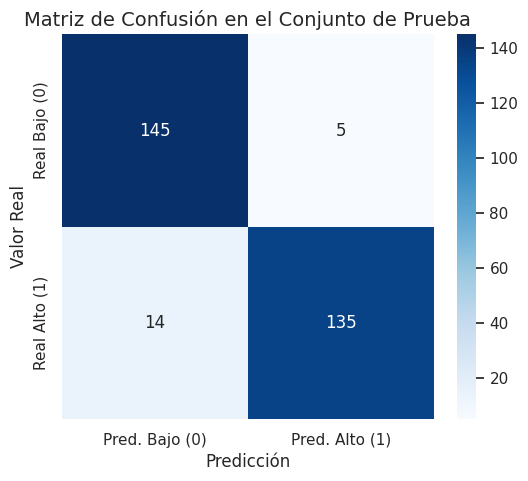


Reporte de Clasificación:
                     precision    recall  f1-score   support

Bajo Engagement (0)     0.9119    0.9667    0.9385       150
Alto Engagement (1)     0.9643    0.9060    0.9343       149

           accuracy                         0.9365       299
          macro avg     0.9381    0.9364    0.9364       299
       weighted avg     0.9380    0.9365    0.9364       299


Área Bajo la Curva ROC (AUC): 0.9755


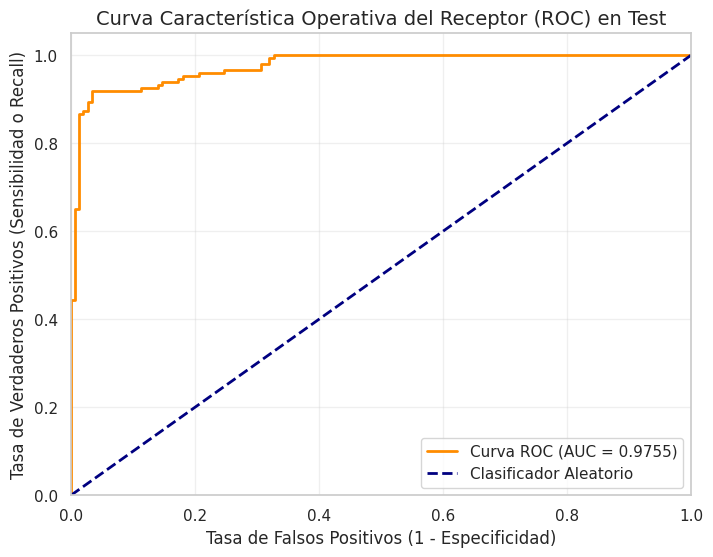

In [32]:
# Necesitamos obtener todas las predicciones y etiquetas del conjunto de prueba.
# Usaremos el 'loaded_model' y el 'test_loader'.

all_targets_test = []
all_predictions_test = []
all_probabilities_test = [] # Para la curva ROC

loaded_model.eval() # Asegurarse de que el modelo está en modo evaluación
with torch.no_grad(): # Desactivar gradientes
    for batch in test_loader:
        images = batch['image'].to(device)
        numerical_features = batch['numerical'].to(device)
        category_features = batch['categories'].to(device)
        tag_features = batch['tags'].to(device)
        targets = batch['target'].to(device)

        outputs = loaded_model(images, numerical_features, category_features, tag_features)

        # Guardar probabilidades (después de sigmoide) para ROC AUC
        probs = torch.sigmoid(outputs)
        all_probabilities_test.extend(probs.cpu().numpy()) # Mover a CPU y convertir a NumPy

        # Convertir logits a predicciones de clase (0 o 1)
        predicted_classes = (probs > 0.5).float()
        all_predictions_test.extend(predicted_classes.cpu().numpy())

        all_targets_test.extend(targets.cpu().numpy())

# Convertir las listas a arrays NumPy para scikit-learn
all_targets_test_np = np.array(all_targets_test).flatten() # Aplanar por si tienen una dim extra
all_predictions_test_np = np.array(all_predictions_test).flatten()
all_probabilities_test_np = np.array(all_probabilities_test).flatten()

print("--- Métricas Detalladas en el Conjunto de Prueba ---")

# --- 1. Matriz de Confusión ---
print("\nMatriz de Confusión:")
cm = confusion_matrix(all_targets_test_np, all_predictions_test_np)
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. Bajo (0)', 'Pred. Alto (1)'],
            yticklabels=['Real Bajo (0)', 'Real Alto (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.show()

# --- 2. Reporte de Clasificación (Precision, Recall, F1-score) ---
print("\nReporte de Clasificación:")
# target_names asegura que las etiquetas en el reporte sean descriptivas
class_report = classification_report(all_targets_test_np, all_predictions_test_np,
                                      target_names=['Bajo Engagement (0)', 'Alto Engagement (1)'],
                                      digits=4) # Número de dígitos para las métricas
print(class_report)

# --- 3. Curva ROC y AUC ---
# Calcular FPR (Tasa de Falsos Positivos), TPR (Tasa de Verdaderos Positivos) y umbrales
fpr, tpr, thresholds = roc_curve(all_targets_test_np, all_probabilities_test_np)
# Calcular el Área Bajo la Curva (AUC)
roc_auc = auc(fpr, tpr)
print(f"\nÁrea Bajo la Curva ROC (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad o Recall)')
plt.title('Curva Característica Operativa del Receptor (ROC) en Test')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Conclusiones de la Evaluación Detallada en el Conjunto de Prueba

Tras evaluar mi mejor modelo en el conjunto de prueba, he obtenido métricas detalladas que me permiten comprender mejor su rendimiento.

### 1. Matriz de Confusión

La matriz de confusión obtenida fue:
[[145   5]
[ 14 135]]

Donde:
* **Verdaderos Negativos (TN): 145**
    * Mi modelo predijo correctamente 145 Puntos de Interés (POIs) como de "Bajo Engagement" cuando realmente lo eran.
* **Falsos Positivos (FP): 5** (Error Tipo I)
    * Mi modelo predijo incorrectamente 5 POIs como de "Alto Engagement" cuando en realidad eran de "Bajo Engagement".
* **Falsos Negativos (FN): 14** (Error Tipo II)
    * Mi modelo predijo incorrectamente 14 POIs como de "Bajo Engagement" cuando en realidad eran de "Alto Engagement".
* **Verdaderos Positivos (TP): 135**
    * Mi modelo predijo correctamente 135 POIs como de "Alto Engagement" cuando realmente lo eran.

**Observaciones de la Matriz de Confusión:**
* El modelo demuestra una alta capacidad para clasificar correctamente ambas clases, como lo indican los altos valores de TN y TP.
* El número de Falsos Positivos es muy bajo (5), lo que significa que cuando el modelo predice que un POI tendrá "Alto Engagement", es muy probable que acierte.
* Hay un número ligeramente mayor de Falsos Negativos (14) en comparación con los Falsos Positivos. Esto indica que el modelo tiende a ser un poco más conservador al predecir la clase "Alto Engagement", "perdiendo" algunas oportunidades de identificar correctamente POIs que sí generarían alta interacción. No obstante, el número sigue siendo bajo en relación con el total de predicciones.

### 2. Curva ROC y Área Bajo la Curva (AUC)

* **Área Bajo la Curva ROC (AUC): 0.9755**

**Observaciones de la Curva ROC y AUC:**
* Un AUC de **0.9755** es un resultado excelente. Indica que mi modelo tiene una capacidad sobresaliente para distinguir entre los POIs que generarán "Alto Engagement" y los que generarán "Bajo Engagement".
* Este valor, muy cercano a 1.0, significa que el modelo es robusto y funciona bien a través de diferentes umbrales de clasificación.
* Confirma que el rendimiento del modelo está muy por encima de un clasificador aleatorio (que tendría un AUC de 0.5).

---
**Implicación General de Estas Métricas:**
La combinación de una matriz de confusión con pocos errores y un AUC muy alto refuerza la conclusión de que el modelo híbrido desarrollado es **altamente efectivo y fiable** para la tarea de predecir el nivel de engagement de los Puntos de Interés Turístico en el conjunto de prueba. Los resultados detallados confirman la alta precisión general observada previamente (93.65%).

## Objetivo del Proyecto

Basándonos en el enunciado, el objetivo principal es:

> **Desarrollar e implementar un modelo avanzado de Deep Learning que permita predecir con precisión el nivel de engagement que generarán distintos puntos de interés (POIs) turísticos.**

Este modelo debe ayudar a plataformas como **Artgonuts** a:

- **Optimizar la selección y priorización de contenido** para maximizar la interacción del usuario.
- **Mejorar la experiencia del usuario** al destacar contenido más relevante y atractivo.

---

## Resultados Clave en el Conjunto de Prueba

**Precisión General:** `93.65%`  
**AUC:** `0.9755`

### Para la clase **"Alto Engagement"** (Positiva, Clase 1):

- **Precision:** `0.9643` (Cuando el modelo dice "Alto", acierta el 96.43% de las veces).
- **Recall:** `0.9060` (El modelo identifica el 90.60% de todos los POIs que realmente son de "Alto Engagement").

### Para la clase **"Bajo Engagement"** (Negativa, Clase 0):

- **Precision:** `0.9119` (Cuando el modelo dice "Bajo", acierta el 91.19% de las veces).
- **Recall:** `0.9667` (El modelo identifica el 96.67% de todos los POIs que realmente son de "Bajo Engagement").

### Errores:

- **Falsos Positivos (FP):** `5` (Predijo Alto, era Bajo).
- **Falsos Negativos (FN):** `14` (Predijo Bajo, era Alto).

---

## Interpretación Fundamentada

### Eficacia General del Modelo

Una **precisión general del 93.65%** y un **AUC de 0.9755** indican que el modelo híbrido desarrollado es altamente efectivo y fiable para distinguir entre POIs que probablemente generarán un alto engagement y aquellos que no.

> Este rendimiento **supera con creces a un clasificador aleatorio** y demuestra la capacidad del modelo para **aprender patrones complejos** a partir de datos visuales y metadatos.

---

## Implicaciones Prácticas para una Plataforma Turística (como Artgonuts)

### Optimización de Contenido

- La **alta precisión para la clase "Alto Engagement" (96.43%)** es particularmente valiosa.
- Si la plataforma destaca POIs que el modelo predice como de "Alto Engagement", la gran mayoría de esas recomendaciones serán acertadas.
- Los **5 Falsos Positivos** representan un coste bajo (se destacarían pocos POIs que no resultan tan atractivos).

### Identificación de Contenido Menos Atractivo

- La **alta recall para "Bajo Engagement" (96.67%)** indica que el modelo es muy efectivo filtrando contenido poco interesante.
- Esto puede guiar decisiones sobre:
  - No promocionar activamente ciertos POIs.
  - Mejorar contenido (descripciones, imágenes, etc.).

### Oportunidades Perdidas (Falsos Negativos)

- Los **14 Falsos Negativos** son POIs que el modelo no identificó como de "Alto Engagement" cuando sí lo eran.
- Representan oportunidades perdidas de destacar buen contenido.
- Sin embargo, el modelo sigue captando correctamente más del 90% de los POIs de alto engagement (Recall = 0.9060).

---

## Equilibrio entre Precisión y Recall

- El modelo mantiene un **buen equilibrio general**, con **F1-scores entre 0.93 y 0.94** para ambas clases.
- La ligera diferencia en recall entre clases:
  - **"Alto Engagement" = 0.9060**
  - **"Bajo Engagement" = 0.9667**

Esto sugiere que el modelo es más propenso a:

> Clasificar erróneamente un POI de *alto engagement* como *bajo*, que viceversa.

### Ajuste del Umbral

Dependiendo de los **objetivos del negocio**, se podría:

- Ajustar el umbral de decisión (actualmente en 0.5).
- Aumentar el recall de "Alto Engagement" (a costa de precisión), o viceversa.

> La curva ROC es la herramienta clave para analizar este trade-off.

---

## Cumplimiento del Desafío Central

> ✅ El modelo desarrollado cumple el desafío planteado de manera robusta, demostrando aplicabilidad práctica y resultados estadísticos sólidos.


# Análisis de Errores y Casos Específicos


--- Análisis de Errores (Casos Específicos) ---
Número de Falsos Positivos (Predijo Alto, era Bajo): 5
Número de Falsos Negativos (Predijo Bajo, era Alto): 14

  Mostrando hasta 5 ejemplos de Falso Positivo:

    ----------------------------------------------------
    ID del POI: d5c11570-41c3-40d2-bc1a-b3217780cd2c
    Nombre: Estatua de Adolfo Alsina
    Tipo de Error: Falso Positivo
    Target Real: Bajo Engagement
    Predicción del Modelo: Alto Engagement
    Engagement Score (calculado): 0.2129
    Categorías: ['Patrimonio', 'Escultura']
    Tags (primeros 5): ['Adolfo Alsina', 'Estatua']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/d5c11570-41c3-40d2-bc1a-b3217780cd2c/main.jpg


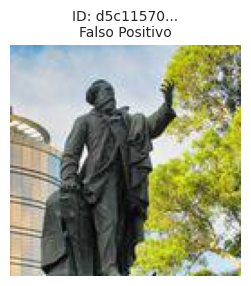

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: 962b4b26-8007-41d1-b306-06cba5925915
    Nombre: Val do río Navea
    Tipo de Error: Falso Positivo
    Target Real: Bajo Engagement
    Predicción del Modelo: Alto Engagement
    Engagement Score (calculado): 0.2960
    Categorías: ['Naturaleza']
    Tags (primeros 5): ['Naturaleza', 'Paisaje', 'Galicia', 'Conservación', 'Vegetación']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/962b4b26-8007-41d1-b306-06cba5925915/main.jpg


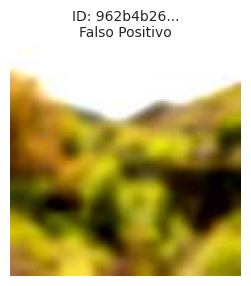

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: 7538638e-cf7e-4f79-86f9-1716cd5e173d
    Nombre: Teatro Lope de Vega y Hotel Emperador
    Tipo de Error: Falso Positivo
    Target Real: Bajo Engagement
    Predicción del Modelo: Alto Engagement
    Engagement Score (calculado): 0.2411
    Categorías: ['Arquitectura', 'Historia', 'Cultura']
    Tags (primeros 5): ['Historia', 'Madrid', 'Teatro', 'Lujo', 'Entretenimiento']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/7538638e-cf7e-4f79-86f9-1716cd5e173d/main.jpg


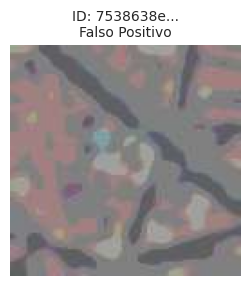

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: f3dfc759-b3b7-4d26-812e-aa2c1e4cbbdf
    Nombre: Aldea de Seceda
    Tipo de Error: Falso Positivo
    Target Real: Bajo Engagement
    Predicción del Modelo: Alto Engagement
    Engagement Score (calculado): 0.2317
    Categorías: ['Patrimonio', 'Historia', 'Arquitectura']
    Tags (primeros 5): ['Historia', 'Aldea', 'Empoleirada', 'Patrimonio', 'Arquitectura medieval']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/f3dfc759-b3b7-4d26-812e-aa2c1e4cbbdf/main.jpg


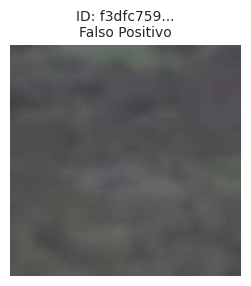

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: fcc3b5be-b254-4c05-aaef-e8bf1eb6bab7
    Nombre: Casas del Cordero
    Tipo de Error: Falso Positivo
    Target Real: Bajo Engagement
    Predicción del Modelo: Alto Engagement
    Engagement Score (calculado): 0.2508
    Categorías: ['Patrimonio', 'Historia', 'Arquitectura']
    Tags (primeros 5): ['Santiago Alonso Cordero', 'Patrimonio', 'Transformación social', 'Madrid', 'Convento de San Felipe el Real']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/fcc3b5be-b254-4c05-aaef-e8bf1eb6bab7/main.jpg


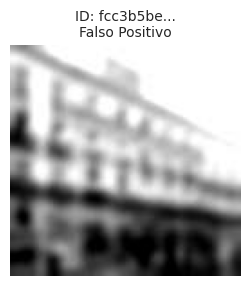

    ----------------------------------------------------

  Mostrando hasta 5 ejemplos de Falso Negativo:

    ----------------------------------------------------
    ID del POI: 8083365a-4ad8-45a2-b08a-e7ea63bf1db0
    Nombre: Megalitos en Asuka
    Tipo de Error: Falso Negativo
    Target Real: Alto Engagement
    Predicción del Modelo: Bajo Engagement
    Engagement Score (calculado): 0.4672
    Categorías: ['Ciencia', 'Cultura', 'Historia', 'Misterio']
    Tags (primeros 5): ['Megalitos', 'Yacimientos', 'Museos', 'Parques']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/8083365a-4ad8-45a2-b08a-e7ea63bf1db0/main.jpg


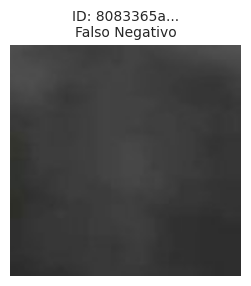

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: caabb21f-5d89-4684-bae6-a9d65c4f9f13
    Nombre: El subsuelo de Orvieto
    Tipo de Error: Falso Negativo
    Target Real: Alto Engagement
    Predicción del Modelo: Bajo Engagement
    Engagement Score (calculado): 0.4675
    Categorías: ['Arquitectura', 'Patrimonio', 'Historia', 'Misterio']
    Tags (primeros 5): ['Subterráneos', 'Santuario', 'Subterráneo', 'Iglesias']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/caabb21f-5d89-4684-bae6-a9d65c4f9f13/main.jpg


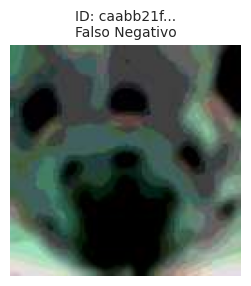

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: 8e9e49a9-08f9-4e01-b0cb-63e2179e318e
    Nombre: Monumento a Francisco de Paula Martí Mora
    Tipo de Error: Falso Negativo
    Target Real: Alto Engagement
    Predicción del Modelo: Bajo Engagement
    Engagement Score (calculado): 0.5544
    Categorías: ['Ciencia', 'Cultura', 'Historia']
    Tags (primeros 5): ['Cultura', 'Retiro', 'Autor', 'Valencia', 'Historia']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/8e9e49a9-08f9-4e01-b0cb-63e2179e318e/main.jpg


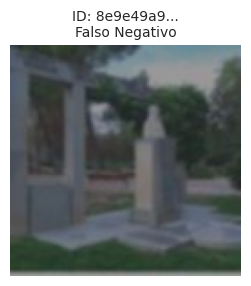

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: 89dc1c80-b06d-478f-8a17-95f749ced327
    Nombre: La harinera Gergert y la fuente Barmalay
    Tipo de Error: Falso Negativo
    Target Real: Alto Engagement
    Predicción del Modelo: Bajo Engagement
    Engagement Score (calculado): 0.4438
    Categorías: ['Cultura', 'Patrimonio', 'Historia', 'Misterio']
    Tags (primeros 5): ['Abandonados', 'Segunda Guerra Mundial', 'Edificios']
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/89dc1c80-b06d-478f-8a17-95f749ced327/main.jpg


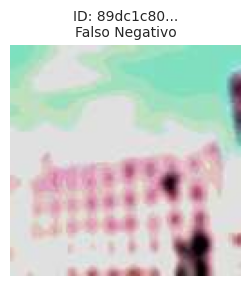

    ----------------------------------------------------

    ----------------------------------------------------
    ID del POI: bcd58127-76bd-44e7-84d8-cc25b46c7962
    Nombre: Clara Campoamor
    Tipo de Error: Falso Negativo
    Target Real: Alto Engagement
    Predicción del Modelo: Bajo Engagement
    Engagement Score (calculado): 0.7739
    Categorías: ['Historia', 'Cultura']
    Tags (primeros 5): []
    Ruta Imagen: /content/drive/My Drive/Colab Notebooks/Proyecto_POI_Engagement/data/data_main/bcd58127-76bd-44e7-84d8-cc25b46c7962/main.jpg


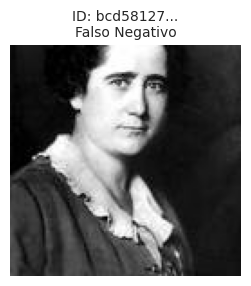

    ----------------------------------------------------


In [33]:
# Convertir a Series de Pandas para facilitar la indexación y el filtrado
targets_series = pd.Series(all_targets_test_np, index=test_indices)
predictions_series = pd.Series(all_predictions_test_np, index=test_indices)

# --- Identificar Índices de Falsos Positivos y Falsos Negativos ---
# Falsos Positivos (FP): Real = 0 (Bajo), Predicción = 1 (Alto)
fp_indices = targets_series[(targets_series == 0) & (predictions_series == 1)].index.tolist()

# Falsos Negativos (FN): Real = 1 (Alto), Predicción = 0 (Bajo)
fn_indices = targets_series[(targets_series == 1) & (predictions_series == 0)].index.tolist()

print(f"\n--- Análisis de Errores (Casos Específicos) ---")
print(f"Número de Falsos Positivos (Predijo Alto, era Bajo): {len(fp_indices)}")
print(f"Número de Falsos Negativos (Predijo Bajo, era Alto): {len(fn_indices)}")

# --- Mostrar Información de Algunos Casos de Error ---
from PIL import Image
import matplotlib.pyplot as plt

def display_poi_info_with_error(poi_indices, error_type, df_reference, num_to_display=3):
    """
    Muestra información e imagen de POIs donde el modelo cometió un error.
    """
    if not poi_indices:
        print(f"No hay {error_type} para mostrar.")
        return

    print(f"\n  Mostrando hasta {num_to_display} ejemplos de {error_type}:")

    # Tomamos una muestra aleatoria de los índices de error
    indices_to_show = random.sample(poi_indices, min(len(poi_indices), num_to_display))

    for original_idx in indices_to_show:
        poi_data = df_reference.loc[original_idx]
        print(f"\n    ----------------------------------------------------")
        print(f"    ID del POI: {poi_data['id']}")
        print(f"    Nombre: {poi_data['name']}")
        print(f"    Tipo de Error: {error_type}")
        print(f"    Target Real: {'Alto Engagement' if targets_series.loc[original_idx] == 1 else 'Bajo Engagement'}")
        print(f"    Predicción del Modelo: {'Alto Engagement' if predictions_series.loc[original_idx] == 1 else 'Bajo Engagement'}")
        print(f"    Engagement Score (calculado): {poi_data.get('engagement_score', 'N/A'):.4f}") # Uso .get por si la columna no existe
        print(f"    Categorías: {poi_data.get('categories_parsed', 'N/A')}")
        print(f"    Tags (primeros 5): {poi_data.get('tags_parsed', [])[:5]}") # Muestro solo algunos tags para brevedad
        print(f"    Ruta Imagen: {poi_data['full_image_path']}")

        try:
            img = Image.open(poi_data['full_image_path'])
            plt.figure(figsize=(4,3))
            plt.imshow(img)
            plt.title(f"ID: {str(poi_data['id'])[:8]}...\n{error_type}", fontsize=10)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"      Error al mostrar imagen {poi_data['full_image_path']}: {e}")
        print(f"    ----------------------------------------------------")

# Mostrando ejemplos de Falsos Positivos
display_poi_info_with_error(fp_indices, "Falso Positivo", df_meta, num_to_display=min(5, len(fp_indices)))

# Mostrando ejemplos de Falsos Negativos
display_poi_info_with_error(fn_indices, "Falso Negativo", df_meta, num_to_display=min(5, len(fn_indices)))

#  Permutation Feature Importance para Metadatos (Conceptual y Simplificado)

In [36]:
print("\n--- Paso 12.2.B: Mi Permutation Feature Importance (Simplificado para Grupos de Metadatos) ---")

# 1. Calculo mi AUC base en el conjunto de prueba original
baseline_auc = roc_auc_score(all_targets_test_np, all_probabilities_test_np)
print(f"AUC Base en Test: {baseline_auc:.4f}")

# Defino los grupos de características de metadatos que quiero permutar
# Usaré los arrays que prepare antes de crear el PoiDataset para el test set:
# - data_numerical_np[test_indices]
# - data_categories_np[test_indices]
# - data_tags_np[test_indices]
# - image_paths_np[test_indices] (no permutaremos imágenes aquí, sino sus features si tuviéramos una rama separada)

# Por simplicidad, haré una función que toma los datos y el índice de la característica a permutar.
# En este caso, "característica" se referirá a un grupo completo (numéricos, categorías, o tags).

feature_groups_to_permute = {
    "numerical_features": data_numerical_np[test_indices].copy(), # Copio para no modificar el original
    "category_features": data_categories_np[test_indices].copy(),
    "tag_features": data_tags_np[test_indices].copy()
}

# Para obtener las imágenes, las cargaremos normalmente.
# No permutaremos las imágenes en sí, sino el input de sus features a la parte de fusión
# si tuviéramos una forma de aislarlas. Con el modelo actual, es más fácil permutar
# las entradas de metadatos.

importance_scores = {}

for group_name, original_group_data in feature_groups_to_permute.items():
    print(f"\n  Permutando el grupo: {group_name}...")
    permuted_group_data = original_group_data.copy()

    # Permuto las columnas del grupo de características (si es 2D) o todo el array (si es 1D por muestra)
    # Para nuestros datos que son (num_samples, num_features_in_group) o (num_samples, seq_len)
    # vamos a permutar a lo largo del eje de las muestras para cada característica/token_posicion
    # de forma independiente. Una permutación más simple es barajar todas las filas.

    # Permutación simple: barajar las filas del grupo de datos
    np.random.shuffle(permuted_group_data) # Baraja las filas inplace

    # Necesito crear un DataLoader temporal con estos datos permutados
    # Reutilizo los otros datos del test_dataset que no permuto
    if group_name == "numerical_features":
        temp_dataset = PoiDataset(image_paths_np[test_indices], permuted_group_data, data_categories_np[test_indices], data_tags_np[test_indices], targets_np[test_indices], transform=image_transformations)
    elif group_name == "category_features":
        temp_dataset = PoiDataset(image_paths_np[test_indices], data_numerical_np[test_indices], permuted_group_data, data_tags_np[test_indices], targets_np[test_indices], transform=image_transformations)
    elif group_name == "tag_features":
        temp_dataset = PoiDataset(image_paths_np[test_indices], data_numerical_np[test_indices], data_categories_np[test_indices], permuted_group_data, targets_np[test_indices], transform=image_transformations)
    else:
        continue

    temp_loader = DataLoader(temp_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Evalúo el modelo con este grupo de datos permutado
    permuted_probs_list = []
    loaded_model.eval()
    with torch.no_grad():
        for batch in temp_loader:
            images = batch['image'].to(device)
            numerical_features_b = batch['numerical'].to(device)
            category_features_b = batch['categories'].to(device)
            tag_features_b = batch['tags'].to(device)
            # targets_b = batch['target'].to(device) # No necesito targets para predicción

            outputs = loaded_model(images, numerical_features_b, category_features_b, tag_features_b)
            probs = torch.sigmoid(outputs)
            permuted_probs_list.extend(probs.cpu().numpy())

    permuted_auc = roc_auc_score(all_targets_test_np, np.array(permuted_probs_list).flatten())
    importance_scores[group_name] = baseline_auc - permuted_auc # Mayor caída = más importante
    print(f"    AUC con {group_name} permutado: {permuted_auc:.4f}, Caída en AUC: {importance_scores[group_name]:.4f}")

print("\n  Importancia de los Grupos de Características (basado en caída de AUC):")
sorted_importance = sorted(importance_scores.items(), key=lambda item: item[1], reverse=True)
for feature_group, score_drop in sorted_importance:
    print(f"    - {feature_group}: {score_drop:.4f}")


--- Paso 12.2.B: Mi Permutation Feature Importance (Simplificado para Grupos de Metadatos) ---
AUC Base en Test: 0.9755

  Permutando el grupo: numerical_features...
    AUC con numerical_features permutado: 0.9723, Caída en AUC: 0.0032

  Permutando el grupo: category_features...
    AUC con category_features permutado: 0.7409, Caída en AUC: 0.2346

  Permutando el grupo: tag_features...
    AUC con tag_features permutado: 0.9735, Caída en AUC: 0.0020

  Importancia de los Grupos de Características (basado en caída de AUC):
    - category_features: 0.2346
    - numerical_features: 0.0032
    - tag_features: 0.0020


## Conclusiones de la Importancia de Características de Metadatos (Permutation Importance)

He realizado un análisis de importancia de características por permutación para los diferentes grupos de metadatos que alimentan mi modelo híbrido. El objetivo era entender cuánto contribuye cada grupo al poder predictivo del modelo, medido por la caída en el AUC (Área Bajo la Curva ROC) en el conjunto de prueba cuando la información de ese grupo se permuta aleatoriamente.

**AUC Base en el Conjunto de Prueba (modelo completo): 0.9755**

### Resultados de la Permutación por Grupo de Características:

* **`category_features` (Características de Categorías Parseadas):**
    * AUC con este grupo permutado: 0.7409
    * **Caída en AUC: 0.2346**
    * **Interpretación:** Este grupo es, con diferencia, el **más influyente** entre las características de metadatos. Alterar la información de las categorías de los POIs (ej. 'Patrimonio', 'Cultura') degrada severamente el rendimiento del modelo. Esto sugiere que el tipo de atracción es un predictor fundamental del engagement.

* **`numerical_features` (Características Numéricas):**
    * AUC con este grupo permutado: 0.9723
    * **Caída en AUC: 0.0032**
    * **Interpretación:** Las características numéricas (`tier`, `locationLon`, `locationLat`, `xps`, `num_categories_parsed`, `num_tags_parsed`) tienen una importancia moderada. Su contribución es positiva, pero el modelo no depende tan críticamente de ellas como de las categorías.

* **`tag_features` (Características de Tags Parseados):**
    * AUC con este grupo permutado: 0.9735
    * **Caída en AUC: 0.0020**
    * **Interpretación:** Los tags, a pesar de su alta cardinalidad y el uso de embeddings, muestran el menor impacto en el rendimiento del modelo cuando se permutan. Esto podría indicar que mucha de la información predictiva contenida en los tags ya está capturada por las `categories_parsed` (que son mucho más impactantes), o que la estrategia actual de embedding para los tags podría optimizarse más para extraer una señal más fuerte.

### Implicaciones Generales:

* La **categorización principal de un POI (`categories_parsed`) es el factor de metadatos más determinante** para predecir su engagement en mi modelo actual.
* Las características numéricas aportan información útil, aunque de forma secundaria.
* La influencia de los `tags_parsed` individuales, tal como están procesados actualmente, parece ser limitada en comparación con las otras fuentes de metadatos, especialmente las categorías.
* Este análisis no ha aislado la importancia de las características visuales (imágenes) de forma independiente, pero nos da una clara jerarquía de la utilidad de los diferentes tipos de metadatos procesados.


## Propuestas de Mejoras Futuras para Mi Modelo

Basándome en mi análisis y los resultados obtenidos, identifico las siguientes áreas como posibles mejoras futuras para este proyecto:

1.  **Fine-Tuning Avanzado del Componente Visual (CNN):**
    * **Propuesta:** Descongelar progresivamente más capas de la `ResNet18` (o probar una CNN base más grande como `ResNet34` o `ResNet50`) y continuar el entrenamiento con una tasa de aprendizaje muy baja (ej., `1e-5` a `1e-4`).
    * **Justificación:** Adaptar más profundamente los pesos pre-entrenados a las características específicas de las imágenes de POIs turísticos podría mejorar la extracción de features visuales relevantes para el engagement.

2.  **Optimización Exhaustiva de Hiperparámetros:**
    * **Propuesta:** Emplear técnicas de búsqueda de hiperparámetros (ej., Grid Search, Random Search, o herramientas como Optuna) para encontrar la combinación óptima de tasa de aprendizaje, scheduler, batch size, dimensiones de embedding, arquitectura de las MLPs (número de capas, neuronas), y tasas de dropout.
    * **Justificación:** El rendimiento del modelo es sensible a estos hiperparámetros, y una búsqueda sistemática podría desbloquear mejoras adicionales.

3.  **Incorporación de Características Textuales de `shortDescription` y `name`:**
    * **Propuesta:** Utilizar técnicas de NLP más sofisticadas para extraer información de `shortDescription` y `name`. Esto podría incluir:
        * Embeddings de palabras promediados (ej., Word2Vec, GloVe, FastText).
        * Redes Recurrentes (LSTM/GRU) sobre secuencias de embeddings de palabras.
        * Modelos basados en Transformers pre-entrenados (ej., Sentence-BERT) para obtener embeddings de las descripciones completas.
    * **Justificación:** Estas columnas contienen información semántica rica que actualmente no se está aprovechando. Podrían capturar matices sobre el atractivo o la naturaleza del POI que no están en las `categories` o `tags` estructuradas.

4.  **Re-evaluación y Manejo de la Columna `Visits`:**
    * **Propuesta:** Investigar el origen y la naturaleza de la columna `Visits` debido a su rango extremadamente estrecho. Si se pueden obtener datos de visitas más representativos o si se puede derivar una característica más útil de ella (ej., normalizada de forma diferente, o como un indicador de popularidad relativa dentro de un contexto específico), podría reconsiderarse su inclusión.
    * **Justificación:** Intuitivamente, las visitas deberían ser un fuerte indicador de engagement, pero en su forma actual, su utilidad es cuestionable.

5.  **Estrategias Avanzadas para Features de Ubicación:**
    * **Propuesta:** Dado que no se encontraron las columnas `distrito` y `barrio`, y que hay una mezcla de POIs de Madrid y globales:
        * Intentar obtener datos de `distrito/barrio` para los POIs de Madrid a partir de sus coordenadas (`locationLon`, `locationLat`) usando servicios de geocodificación inversa (si la política de datos lo permite).
        * Crear características de distancia a puntos de referencia clave en Madrid.
        * Considerar una característica binaria "es_madrid" o incluso modelar los POIs de Madrid y los "globales" por separado si sus patrones de engagement difieren mucho.
    * **Justificación:** El contexto geográfico detallado puede ser un predictor importante del engagement.

6.  **Data Augmentation para Imágenes:**
    * **Propuesta:** Aunque las imágenes están preprocesadas, aplicar aumentos de datos ligeros durante el entrenamiento (ej., flips horizontales, pequeñas rotaciones, ajustes de brillo/contraste aleatorios).
    * **Justificación:** Esto puede ayudar a que el componente visual del modelo sea más robusto a variaciones menores en las imágenes y a reducir el overfitting, especialmente si se realiza un fine-tuning más extenso de la CNN.

7.  **Experimentación con Arquitecturas de Fusión y Atención:**
    * **Propuesta:** Explorar mecanismos de fusión más avanzados que la simple concatenación, como capas de atención que permitan al modelo ponderar dinámicamente la importancia de las características visuales frente a las de metadatos (o incluso entre diferentes tipos de metadatos) para cada predicción.
    * **Justificación:** Una fusión más "inteligente" podría capturar interacciones más complejas y relevantes entre las diferentes modalidades de datos.

8.  **Análisis de Interpretabilidad Más Profundo y Continuo:**
    * **Propuesta:** Además de Grad-CAM, implementar y analizar sistemáticamente técnicas como LIME o SHAP (aunque SHAP puede ser costoso para modelos de DL) para obtener una comprensión más granular de la importancia de las características tanto visuales como de metadatos.
    * **Justificación:** Entender *por qué* el modelo toma ciertas decisiones puede generar confianza, identificar sesgos y guiar futuras mejoras en la selección de características y el diseño del modelo.